In [3]:
import pandas as pd
from IPython.display import display, HTML
import numpy as np
from sklearn.utils import resample
from IPython.display import display
import numpy as np

# Create a connection with SQL server to get data.
def exec_sql_query(query, param=None):
    
    from sqlalchemy import create_engine
    import urllib
    params = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};SERVER=LAPTOP-C3LFVOFI;DATABASE=student_life;UID=student_sense;PWD=abhinav123")
    engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)
    connection = engine.raw_connection()
    
    try:
        cursor = connection.cursor()
        if(param):
            cursor.execute(query, param)
        else : 
            cursor.execute(query)
            
        results = cursor.fetchall()
        columns = [column[0] for column in cursor.description]
        df = pd.DataFrame.from_records(results, columns=columns)
        cursor.close()
        connection.commit()
    finally:
        connection.close()
    
    del engine
    return df

In [4]:
# Fetching EMA data from SQL.
sql = "select student_id, time, inference from processed_dark_details"
dark_details = exec_sql_query(sql)
dark_details.time = pd.to_datetime(dark_details.time) 


display(dark_details.info())
# display(stress_level.head())
# display(stress_level.info())

# dark_details = pd.merge(left=dark_details, right=stress_level, left_on='date', right_on='date')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41492107 entries, 0 to 41492106
Data columns (total 3 columns):
student_id    int64
time          datetime64[ns]
inference     int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 949.7 MB


None

In [31]:
# Fetching EMA data from SQL.
sql = "Exec get_avg_stress_levels"
stress_level = exec_sql_query(sql)
stress_level.date = pd.to_datetime(stress_level.date) 

C:\Users\Abhinav Shaw\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
C:\Users\Abhinav Shaw\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Users\Abhinav Shaw\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


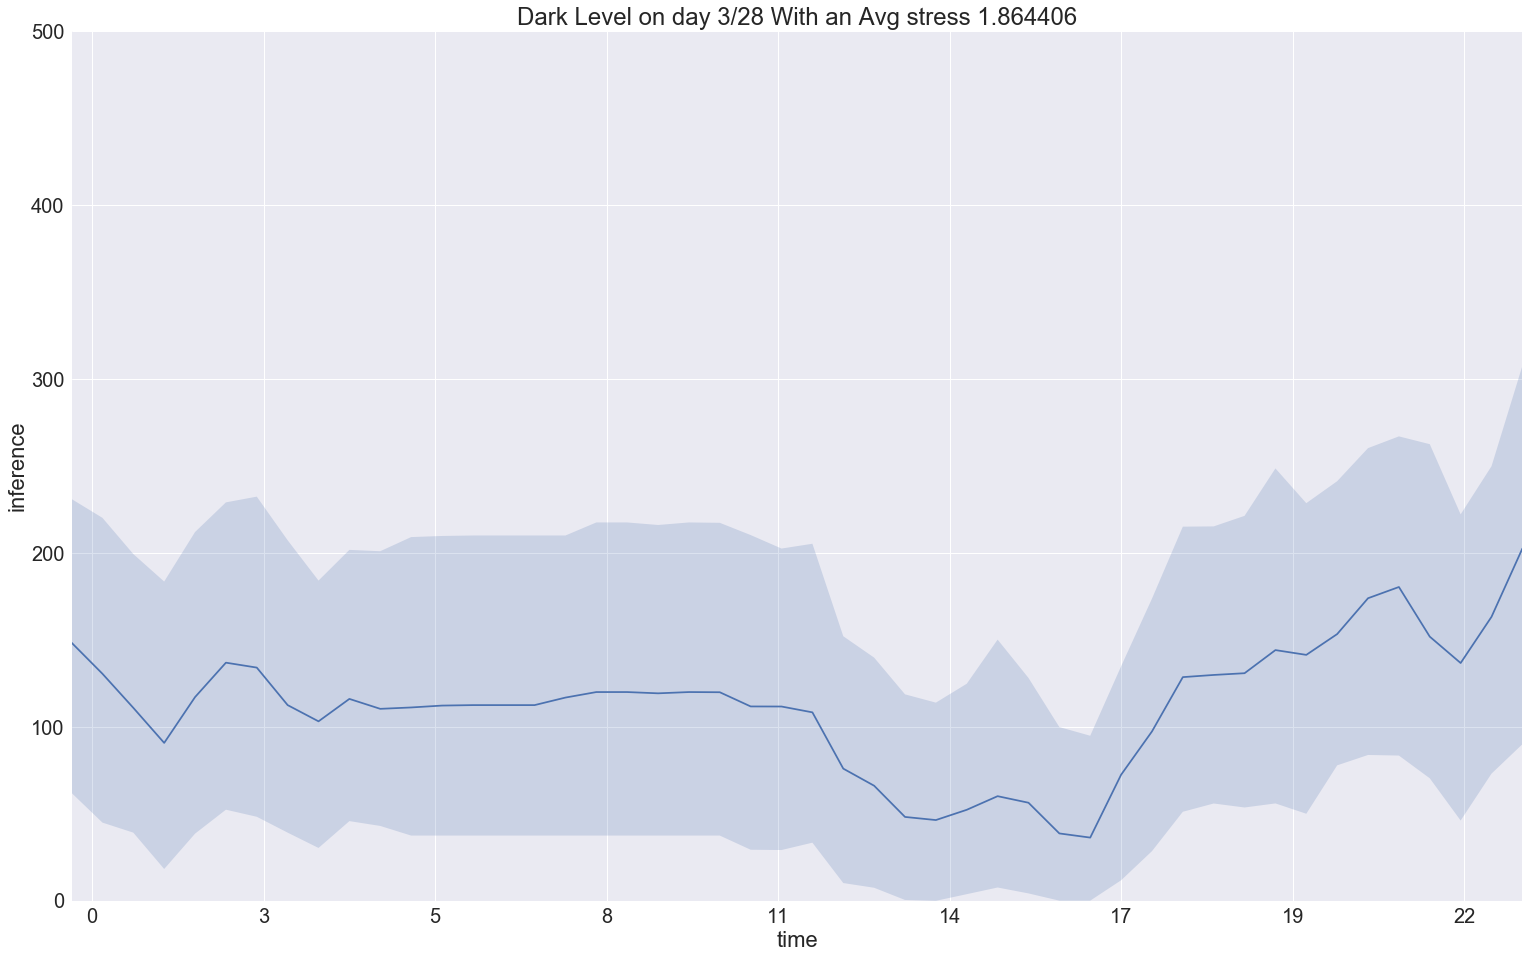

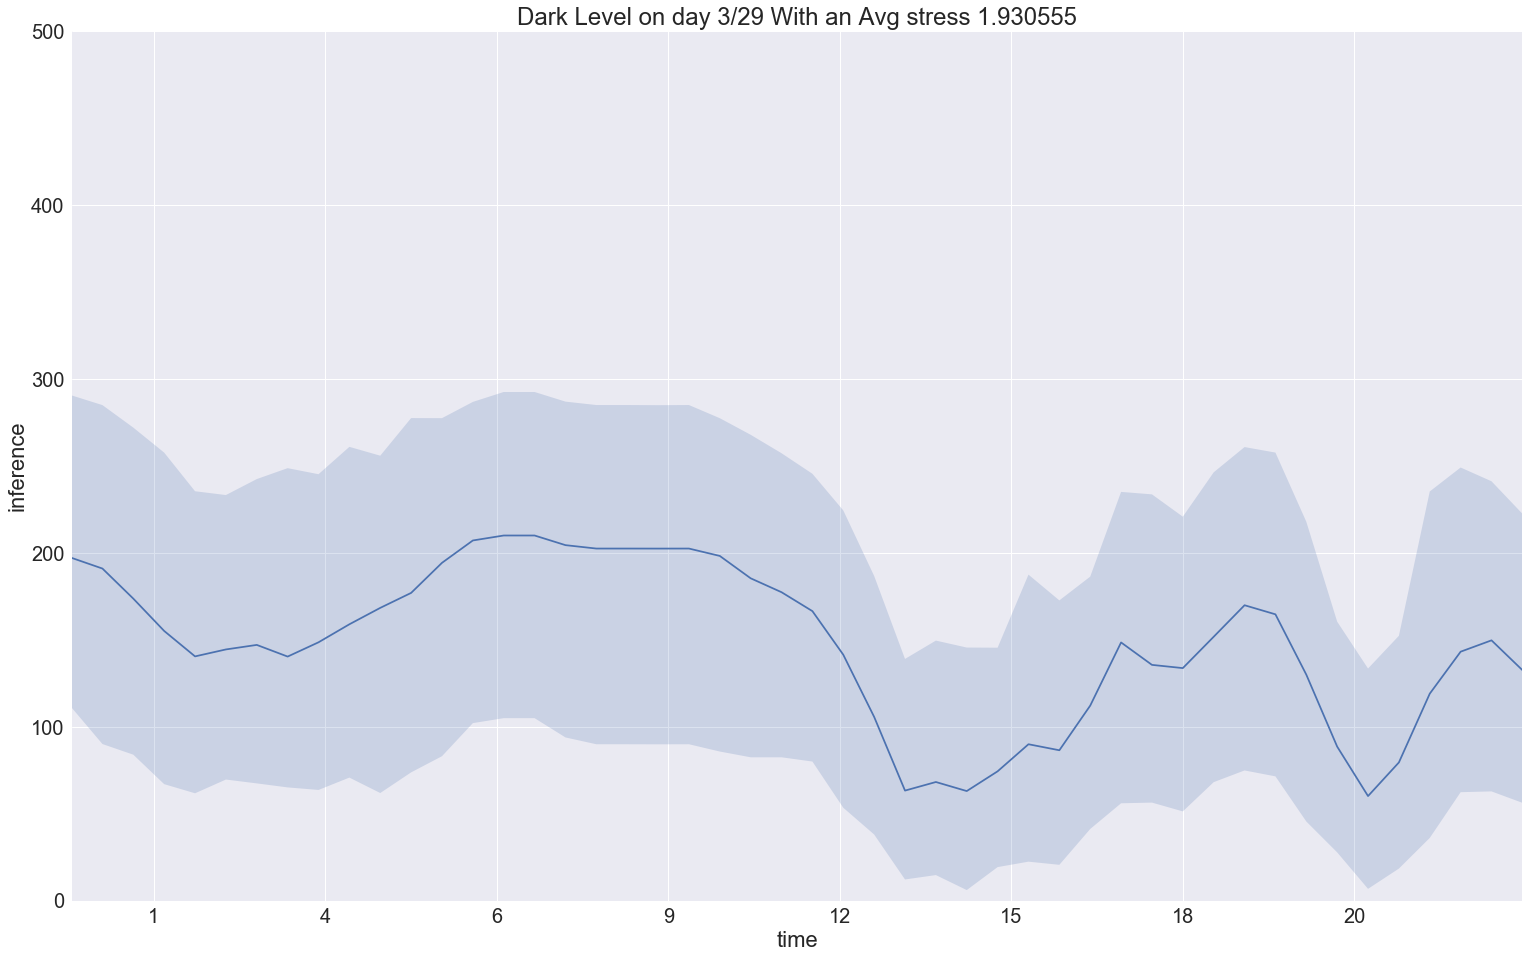

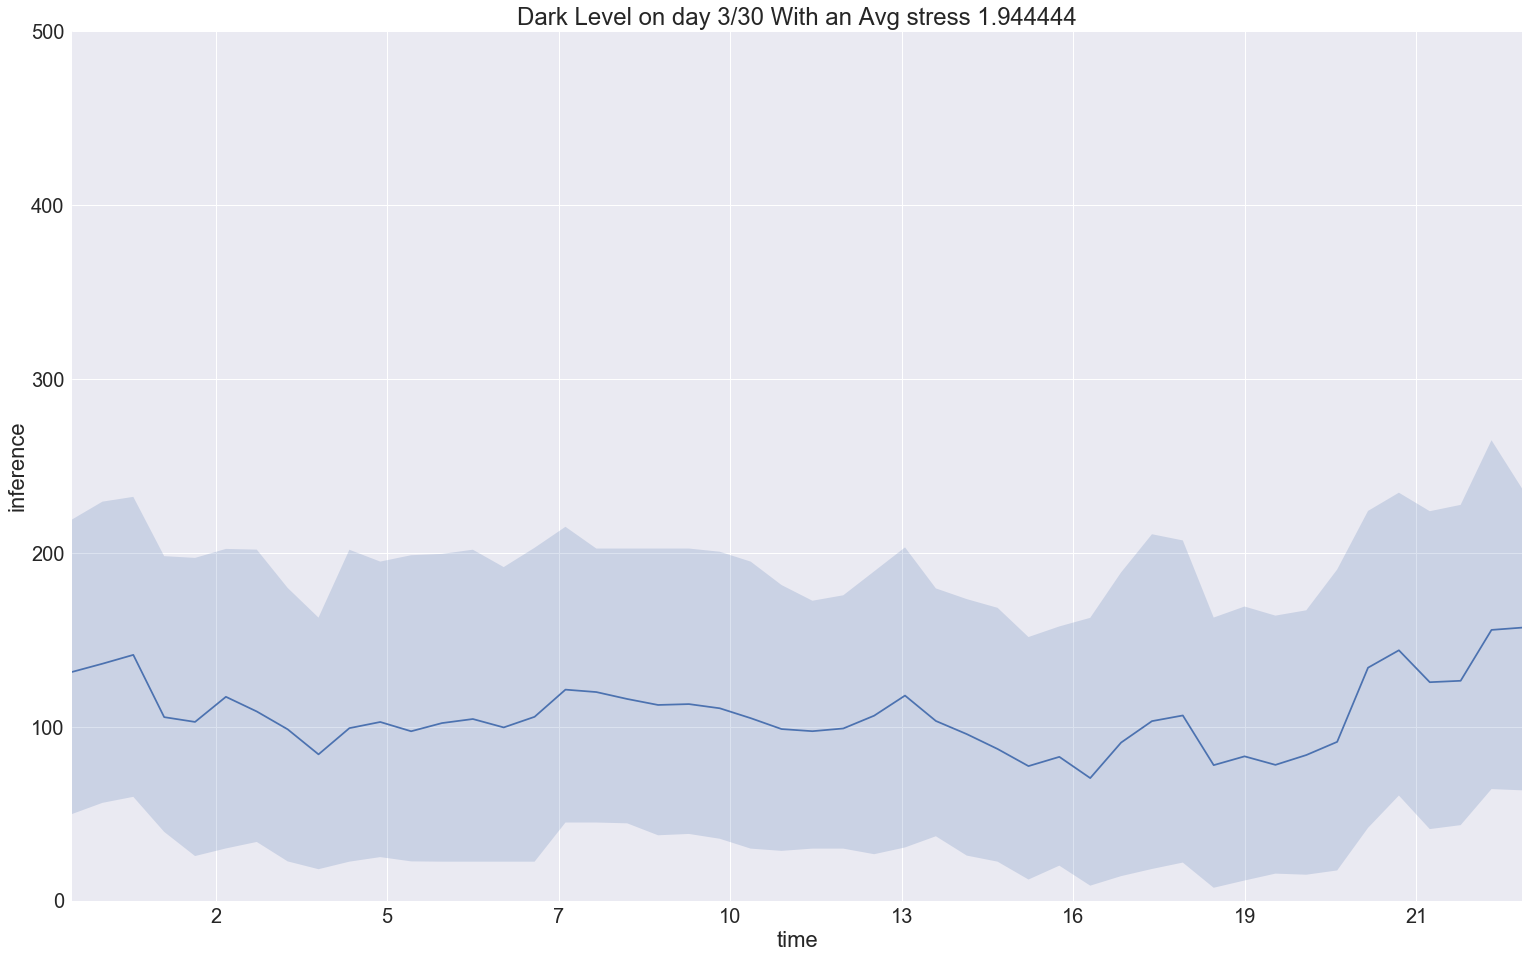

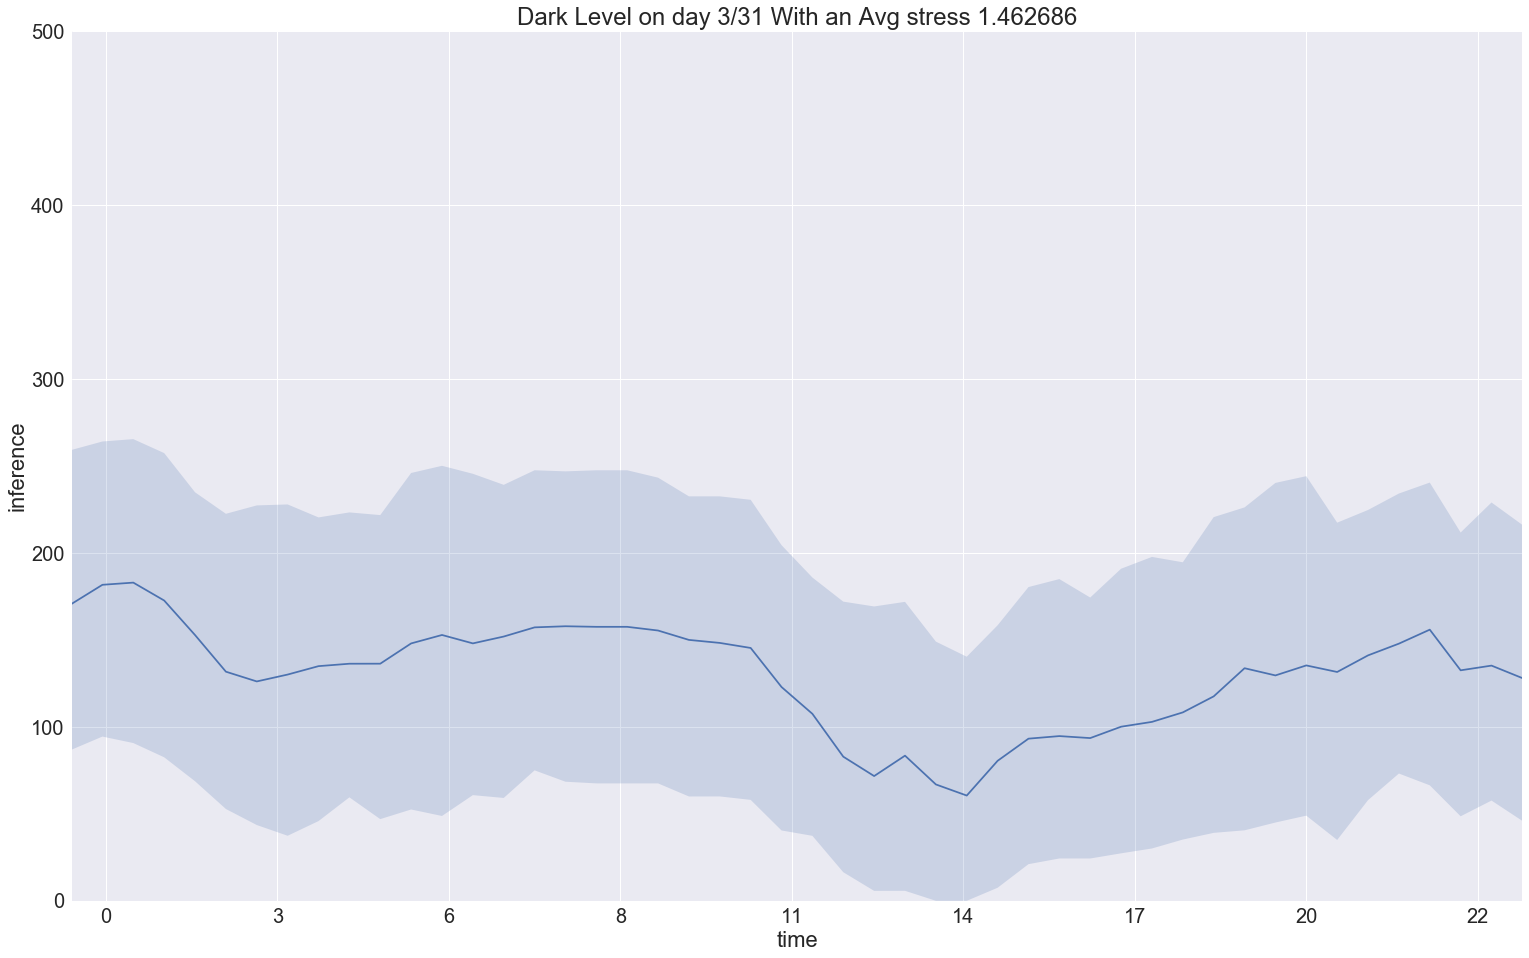

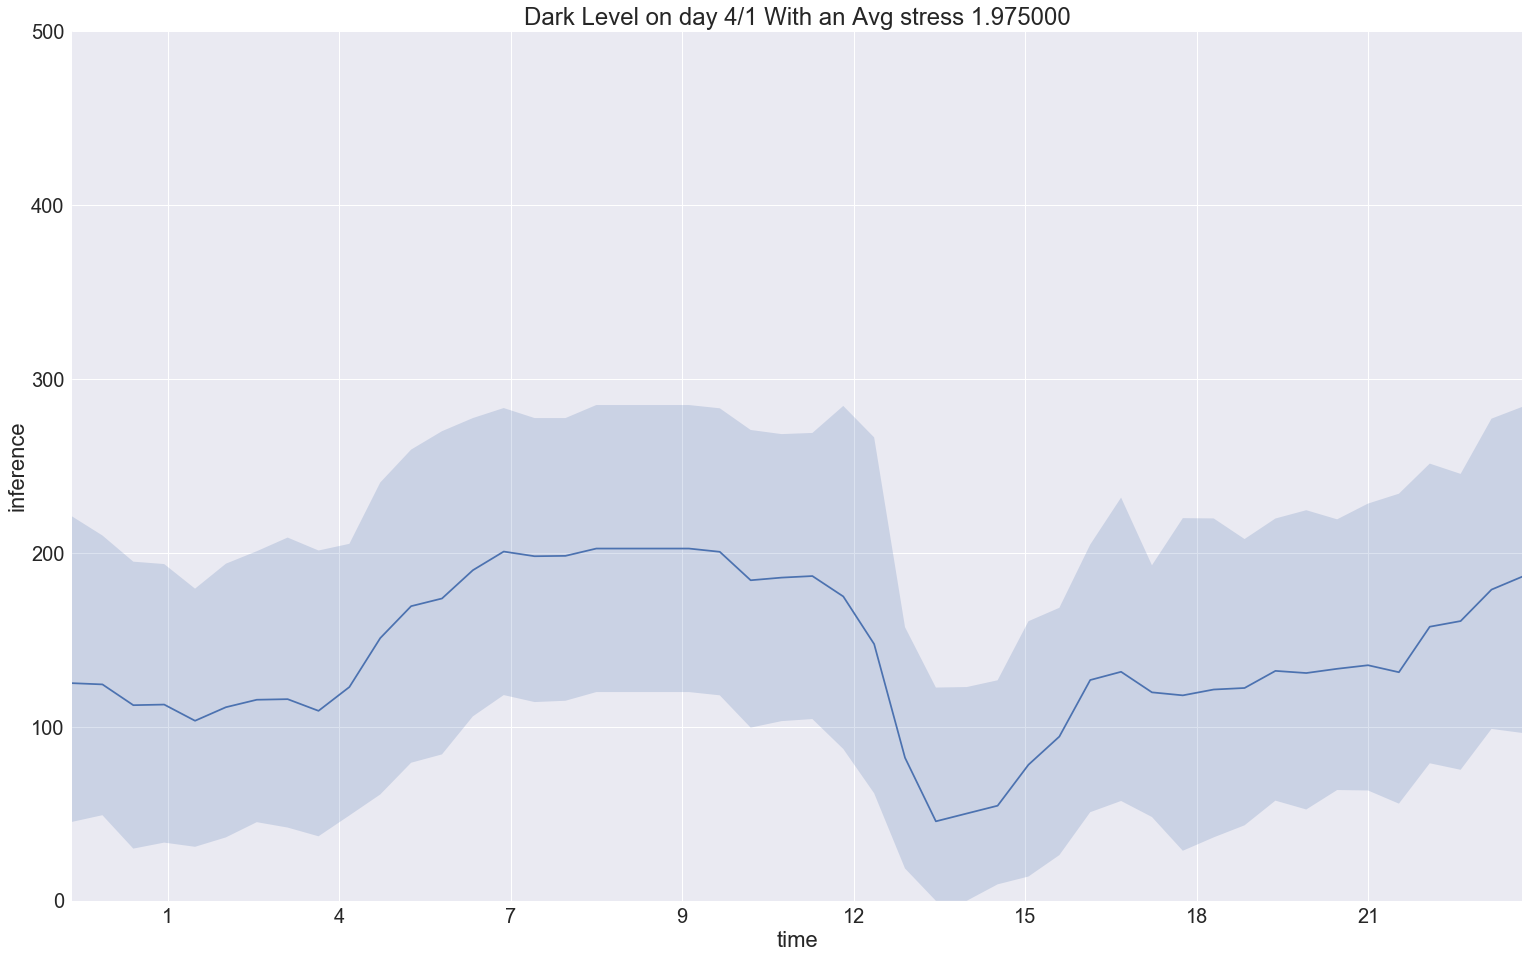

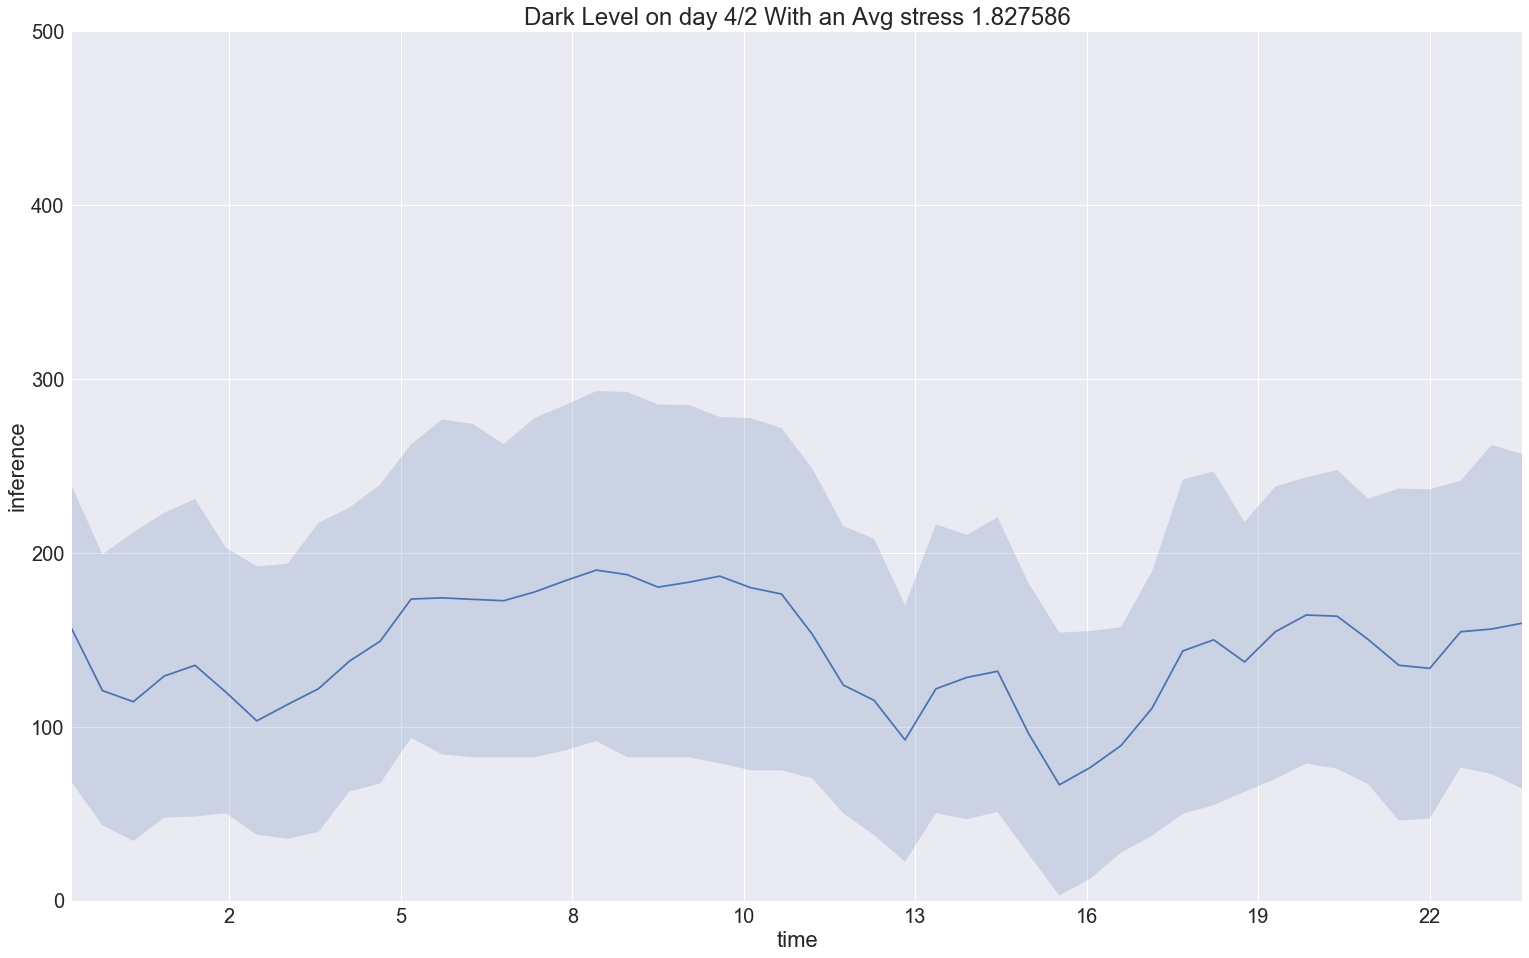

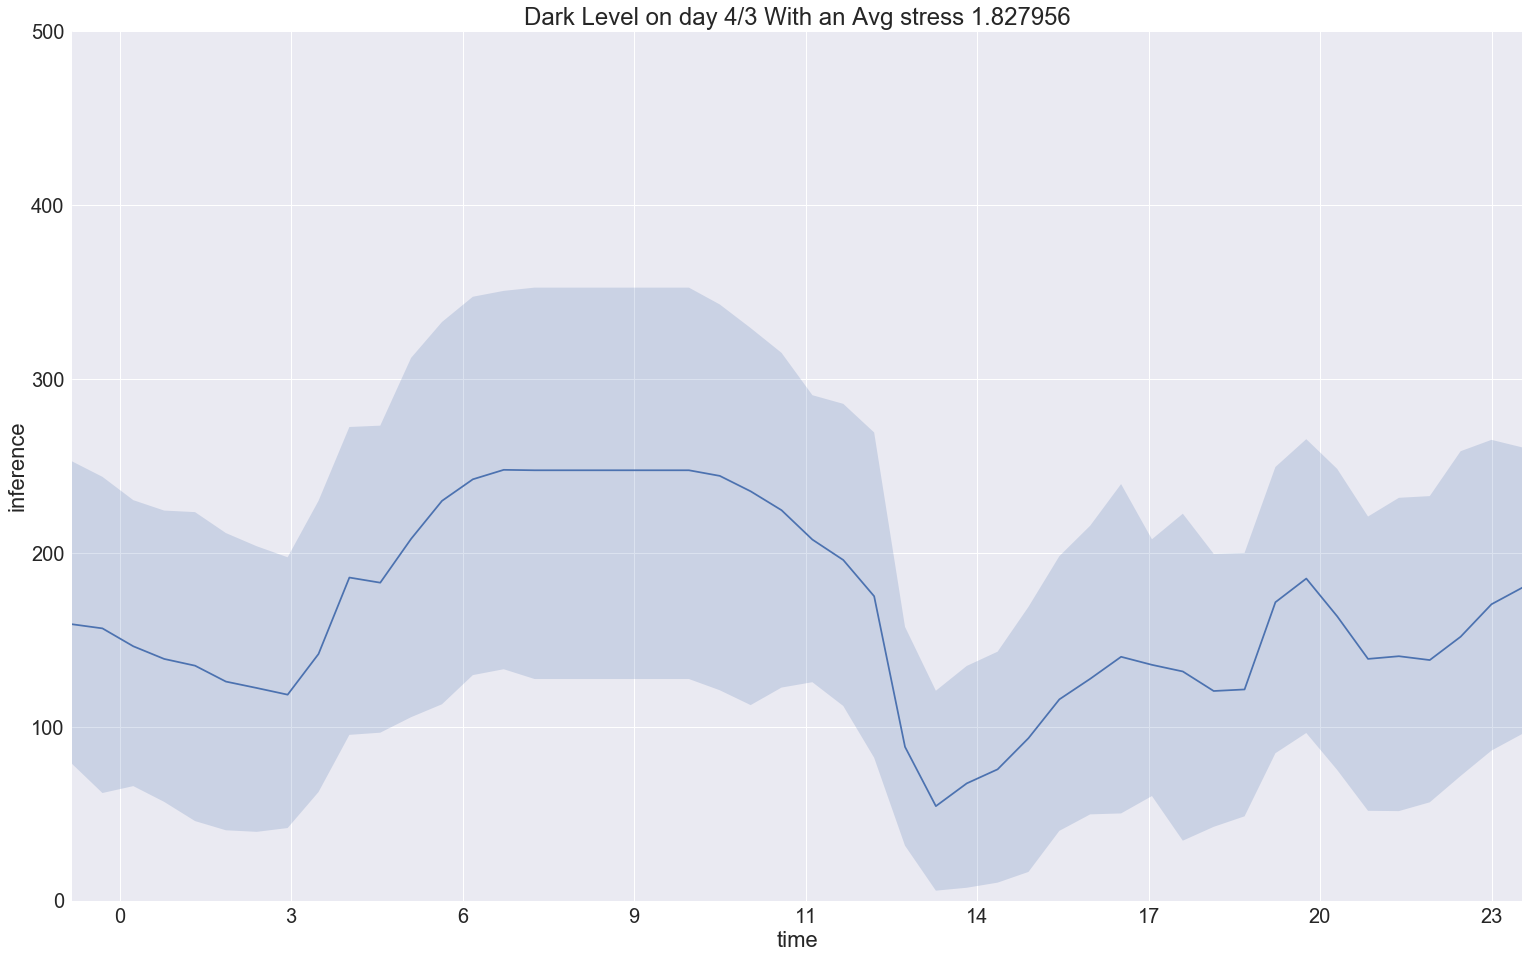

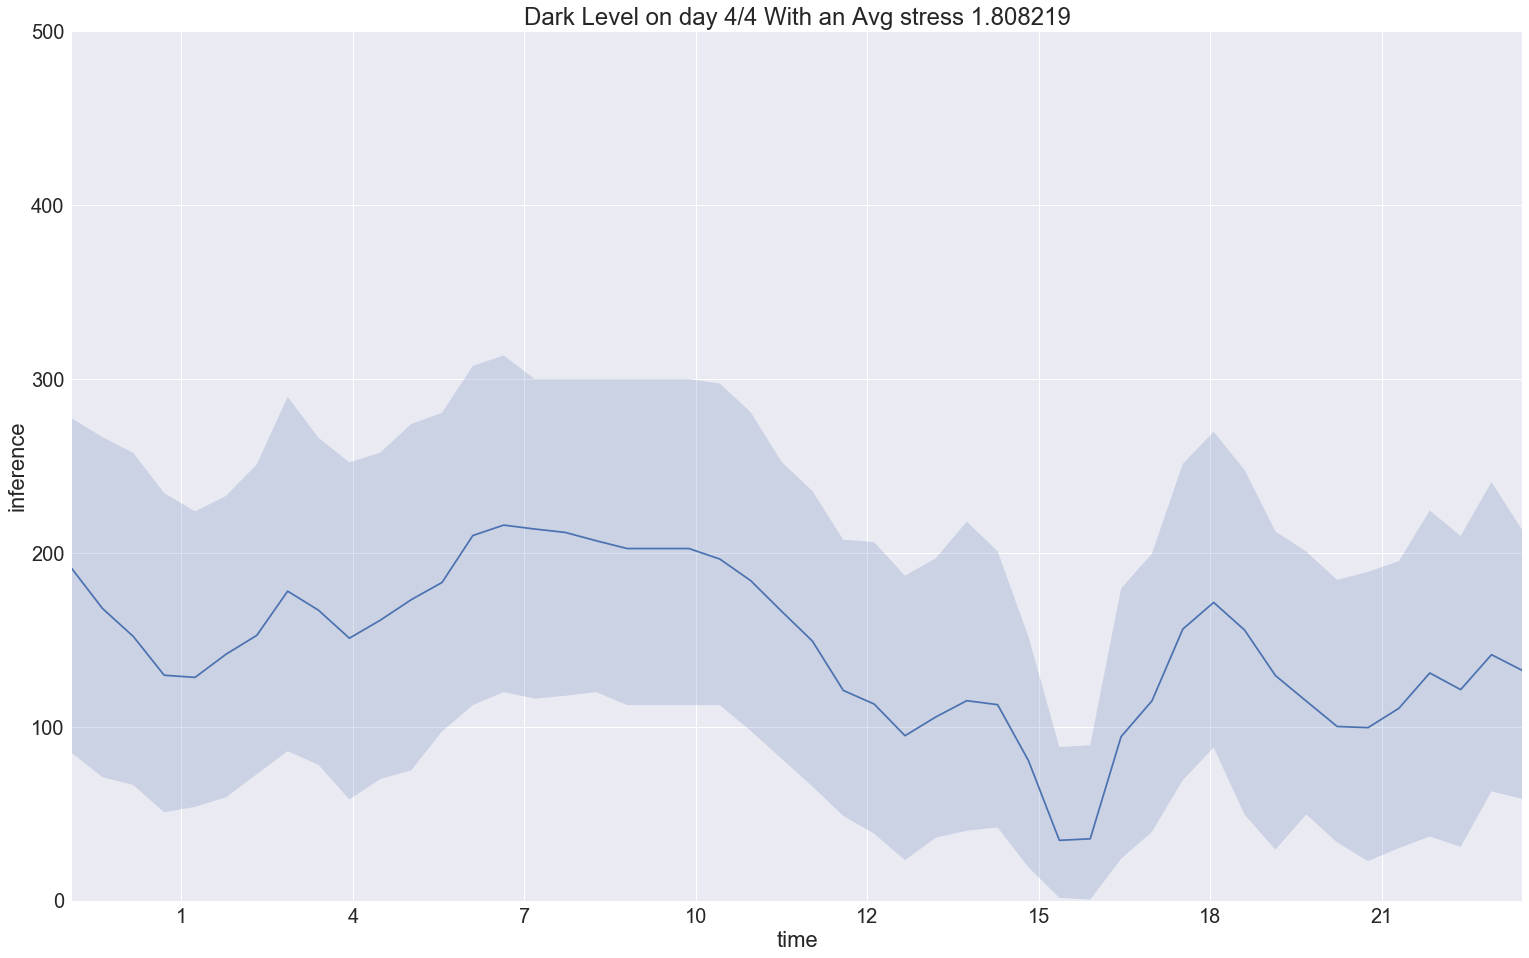

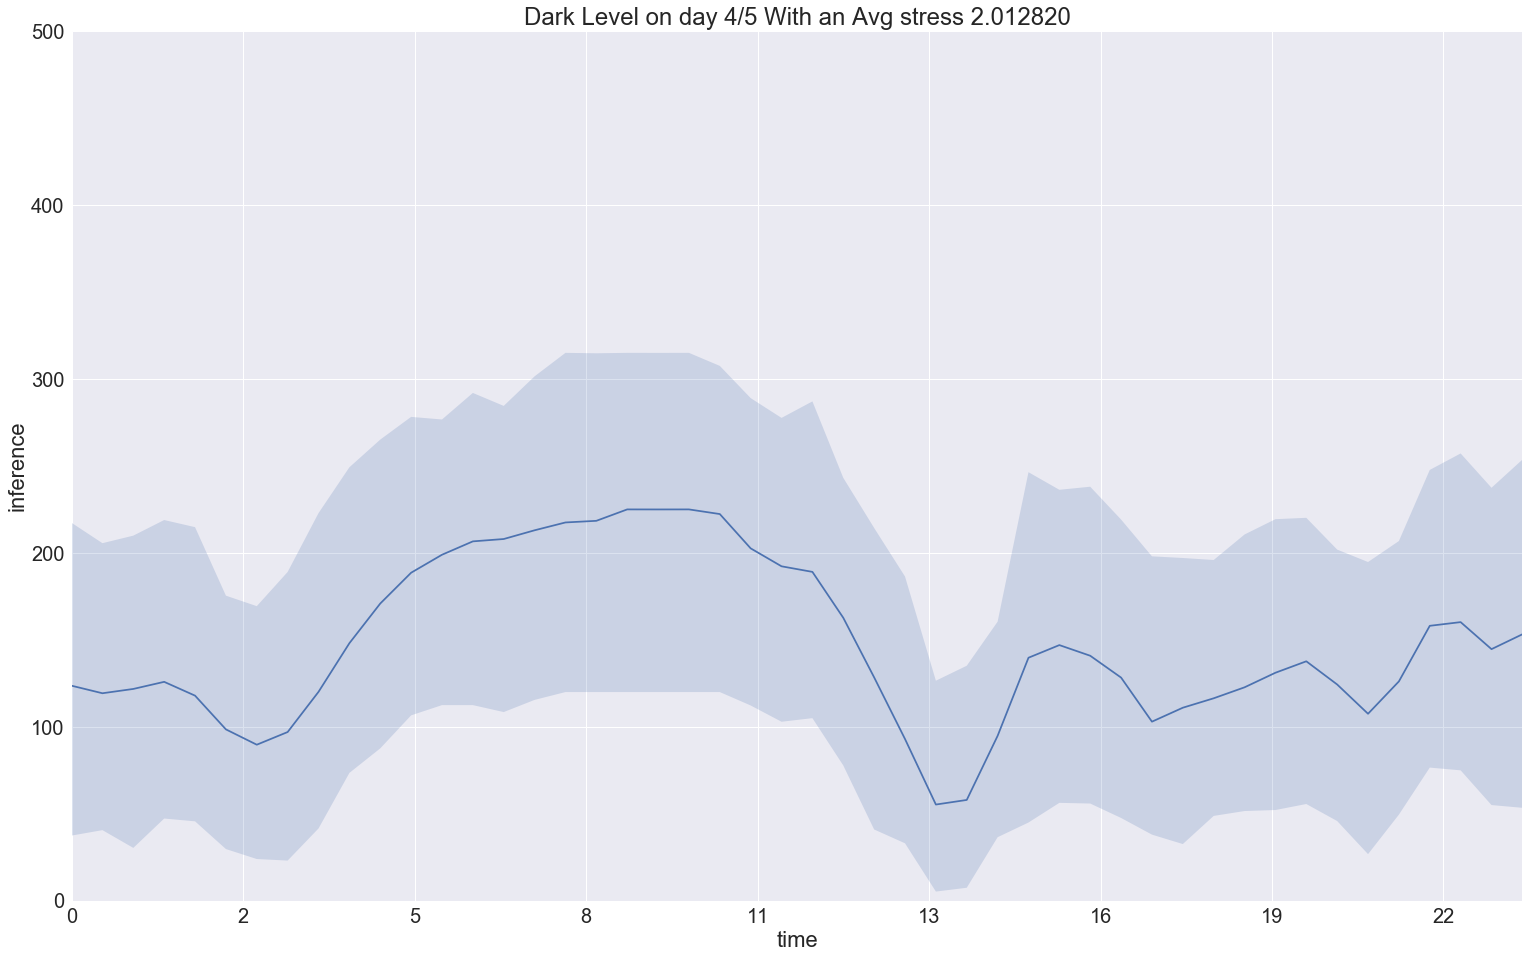

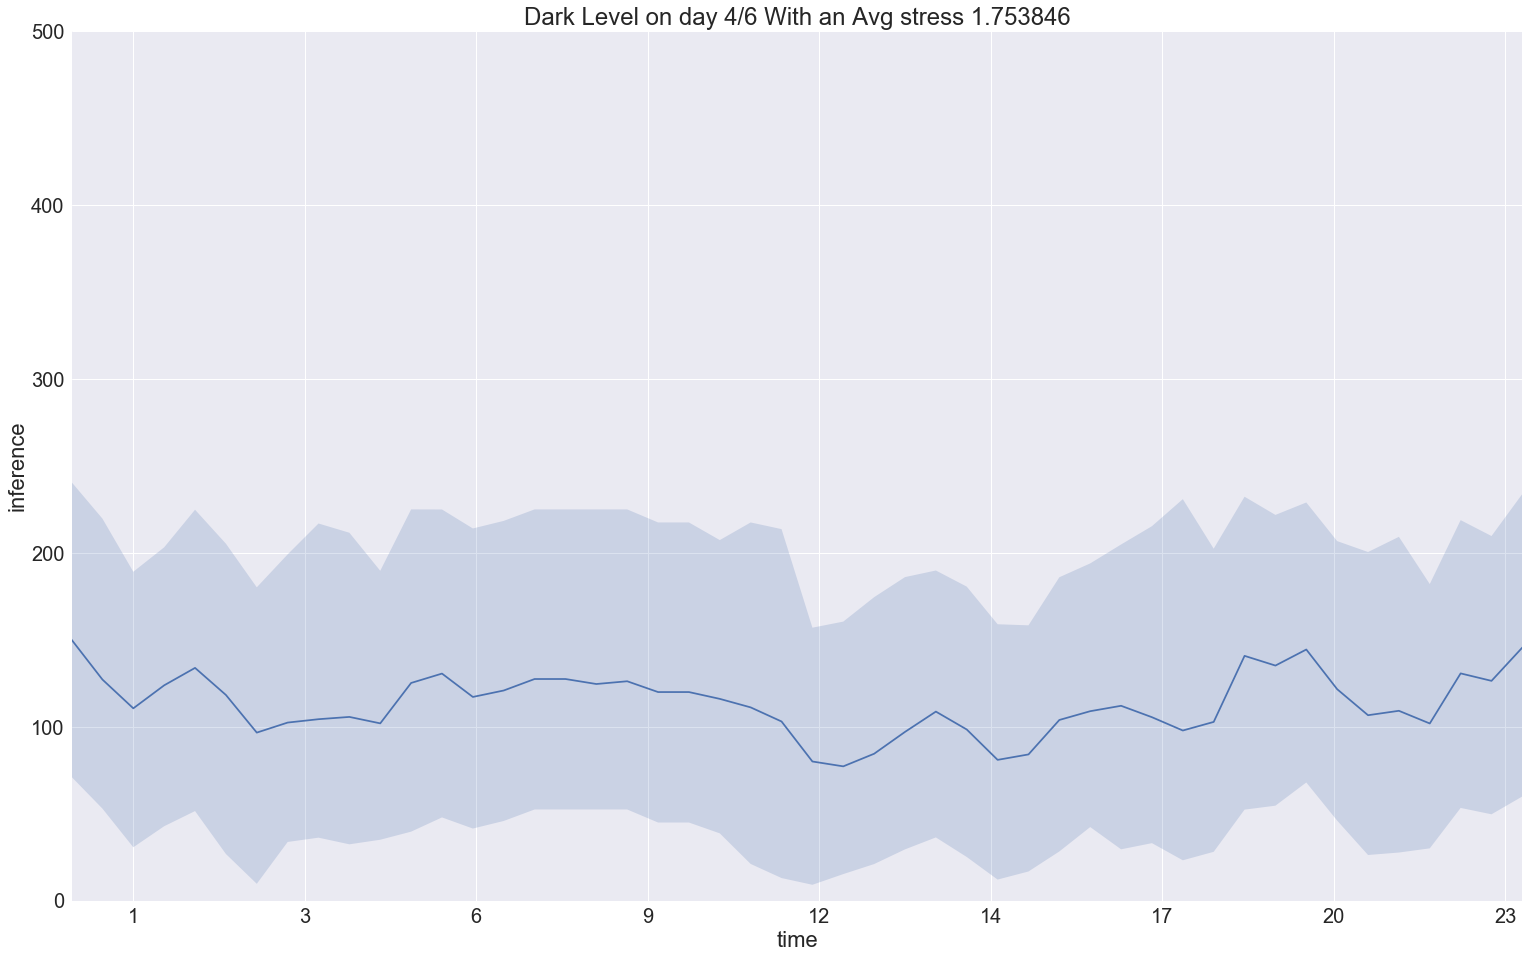

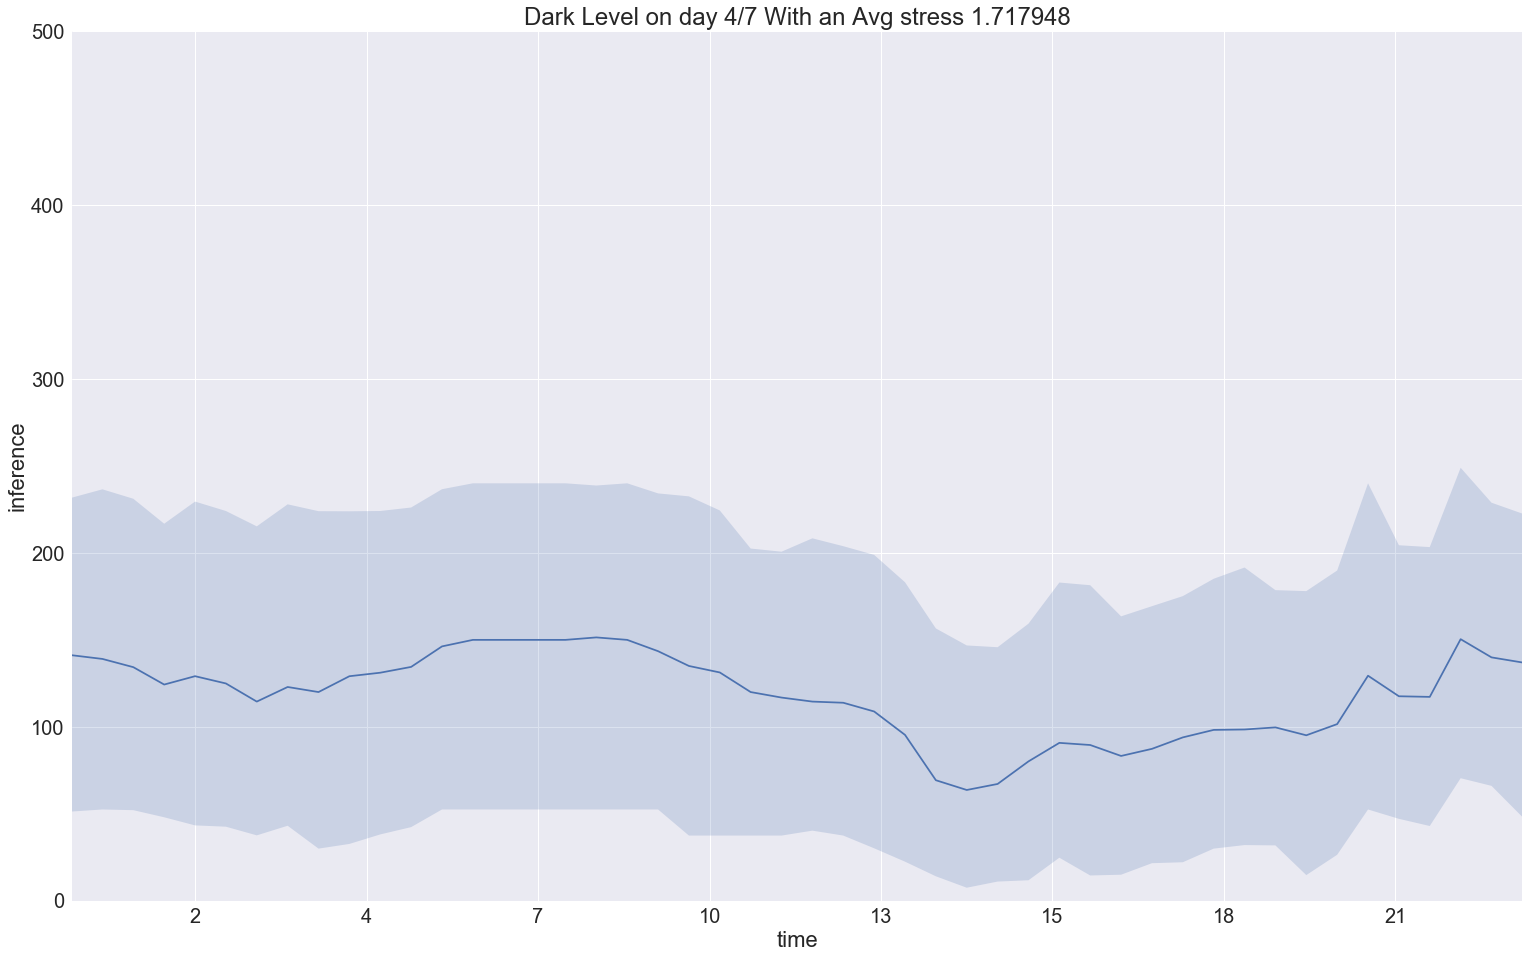

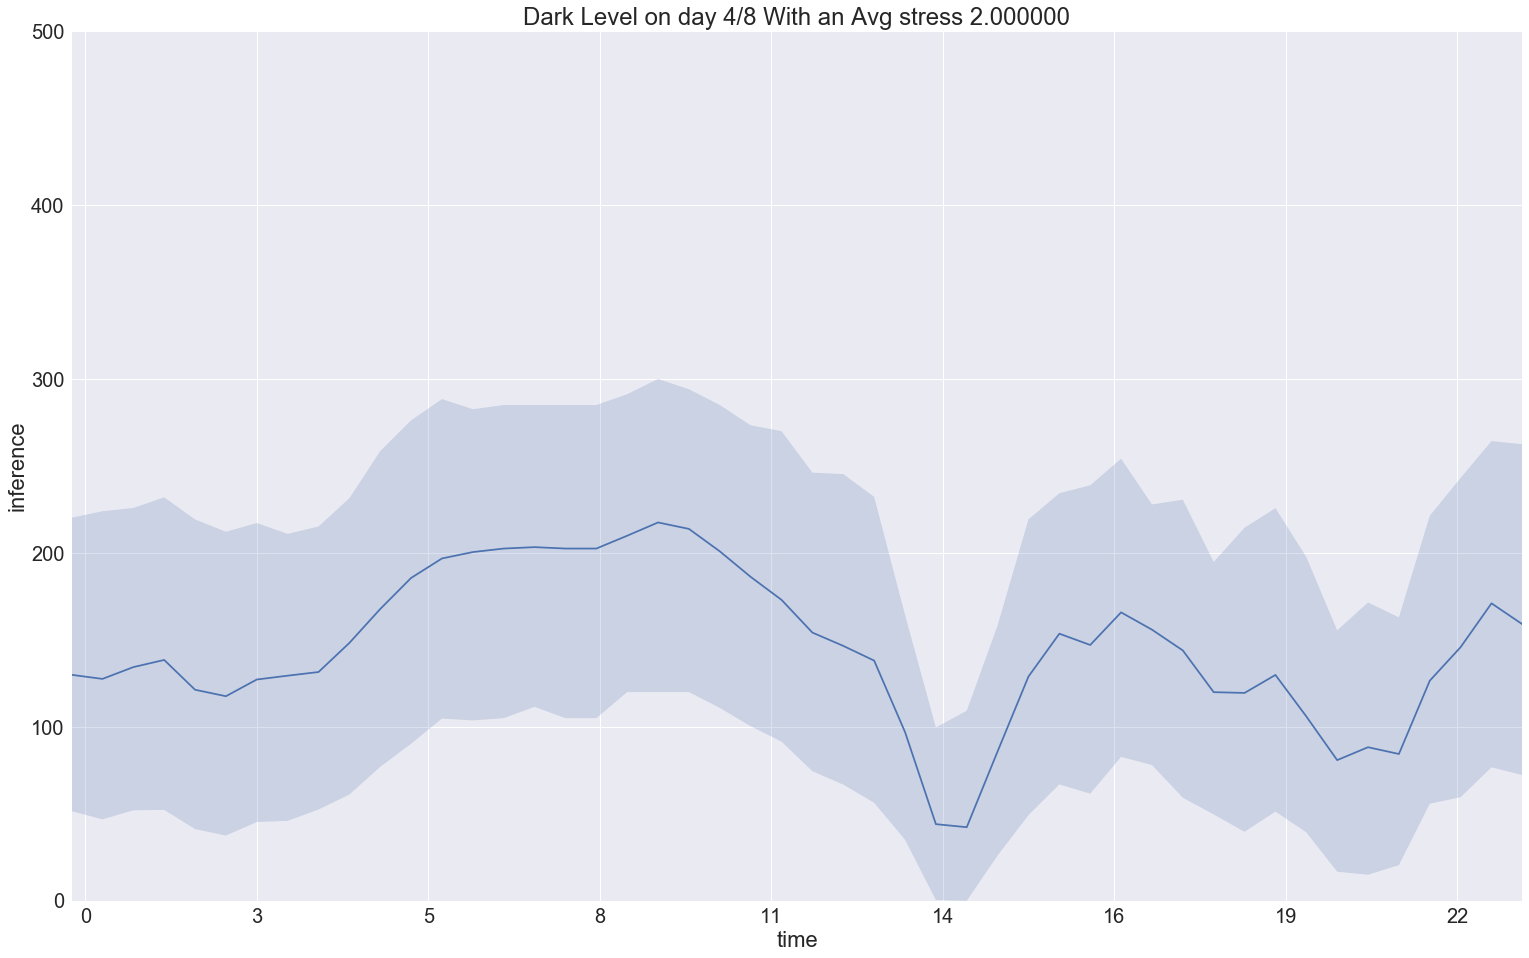

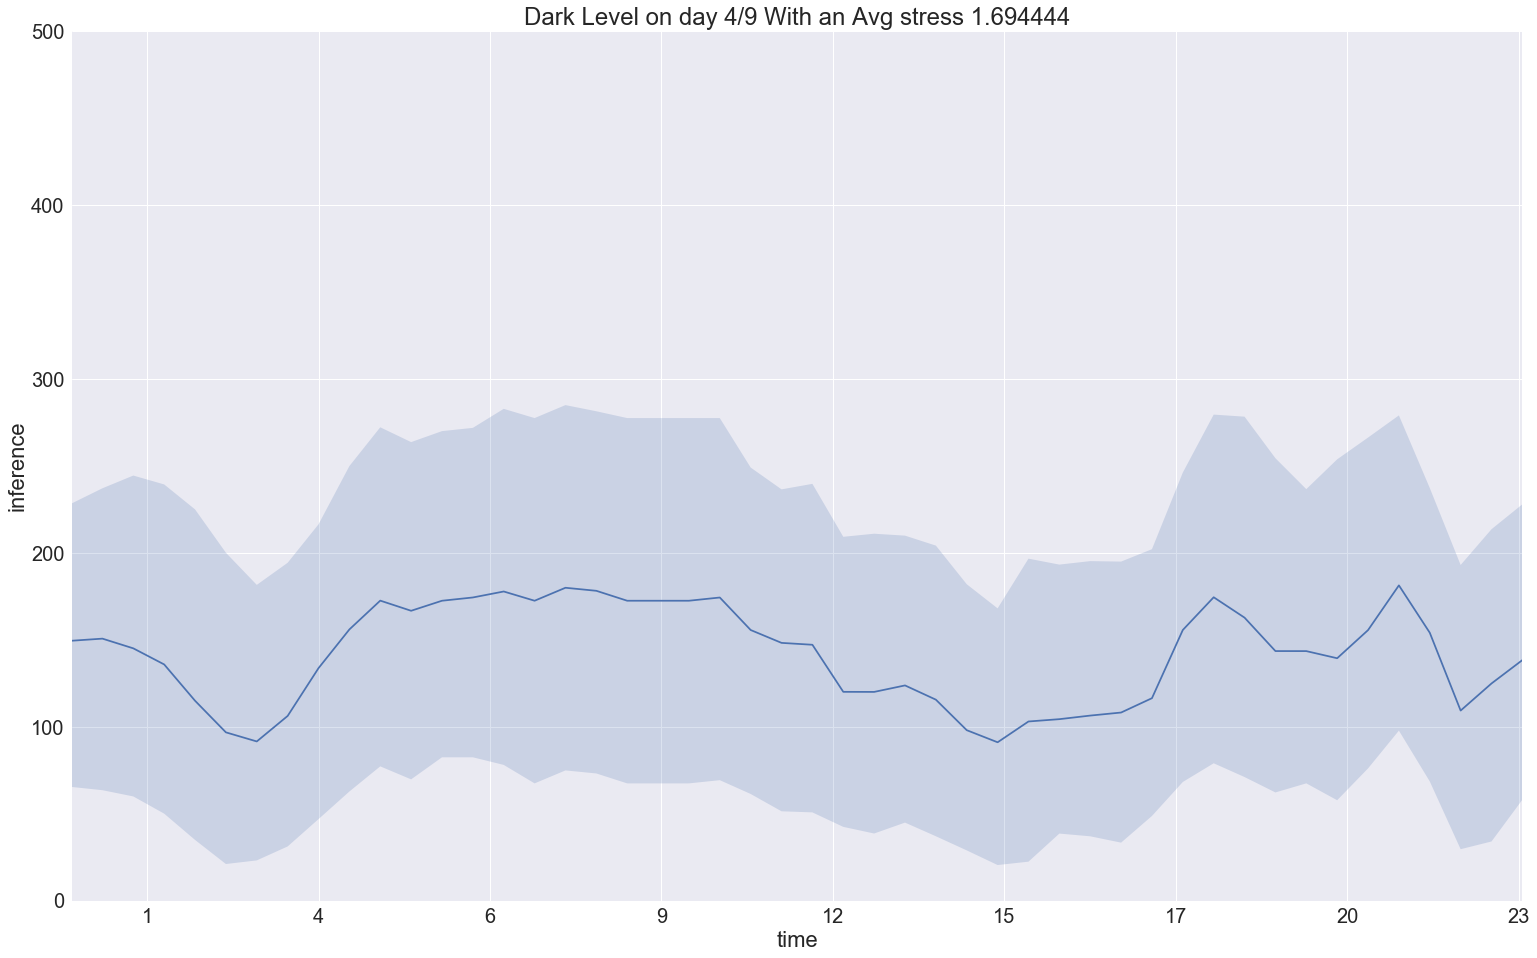

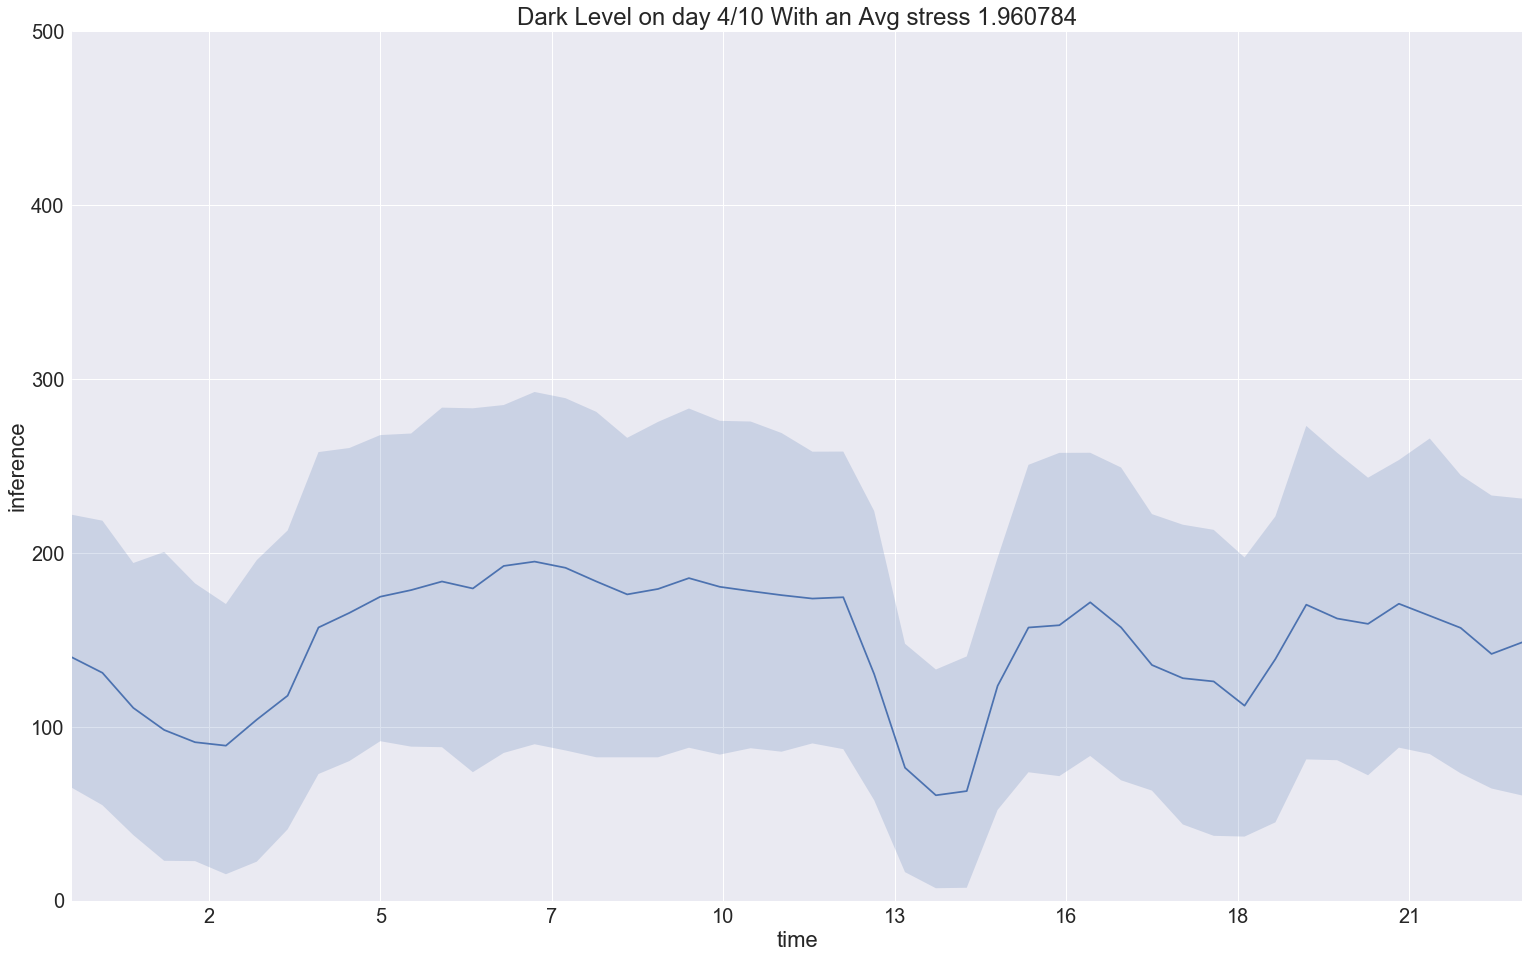

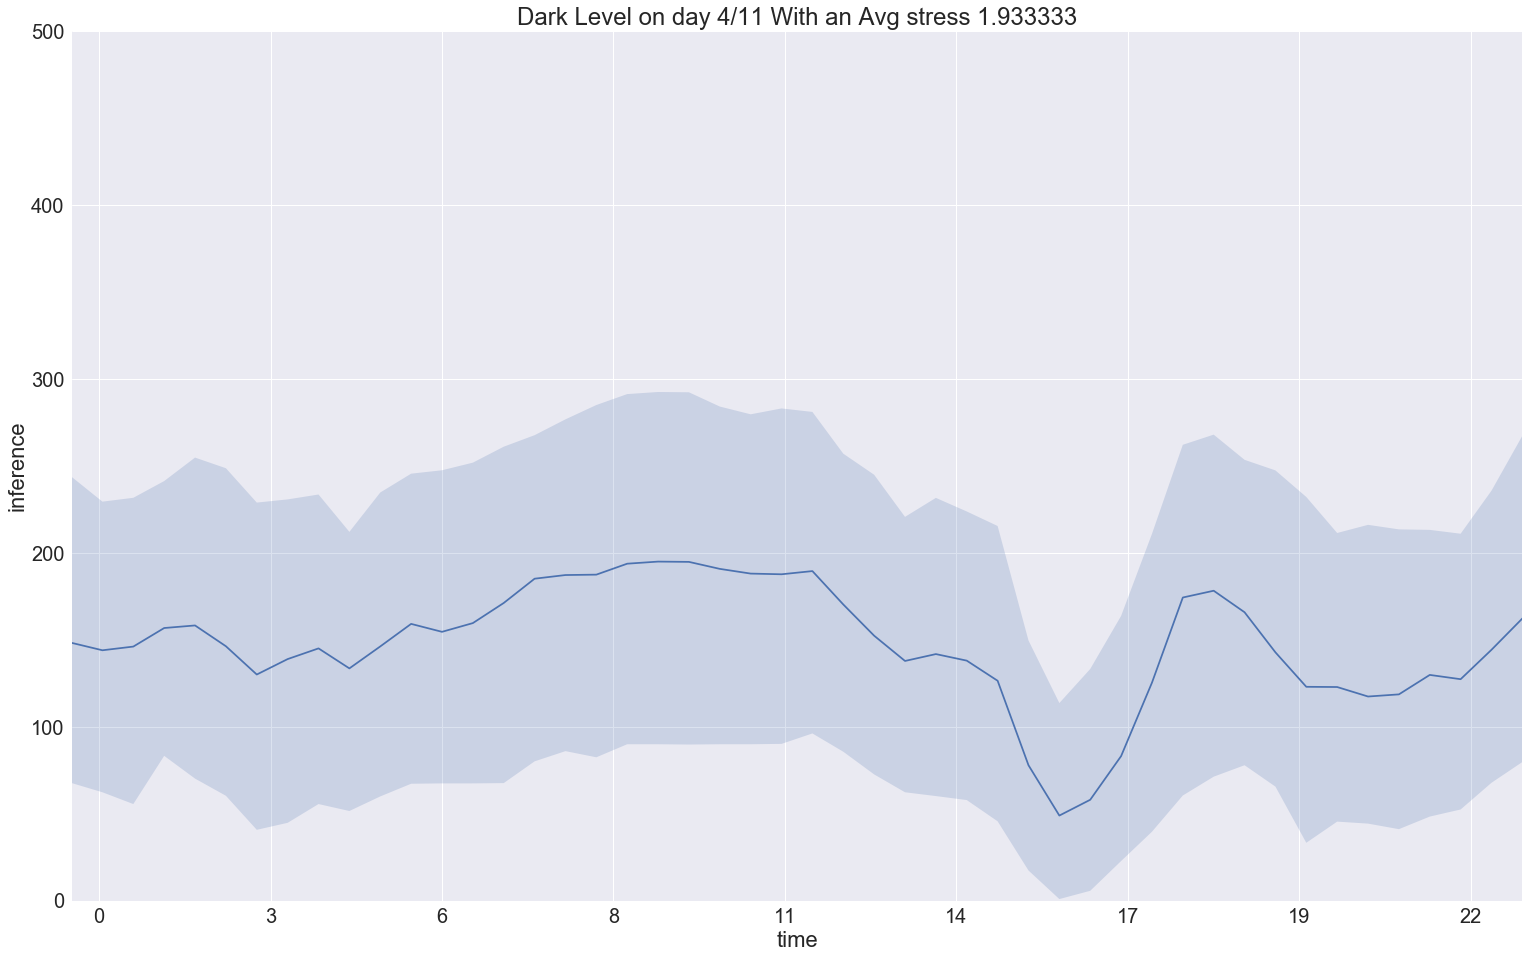

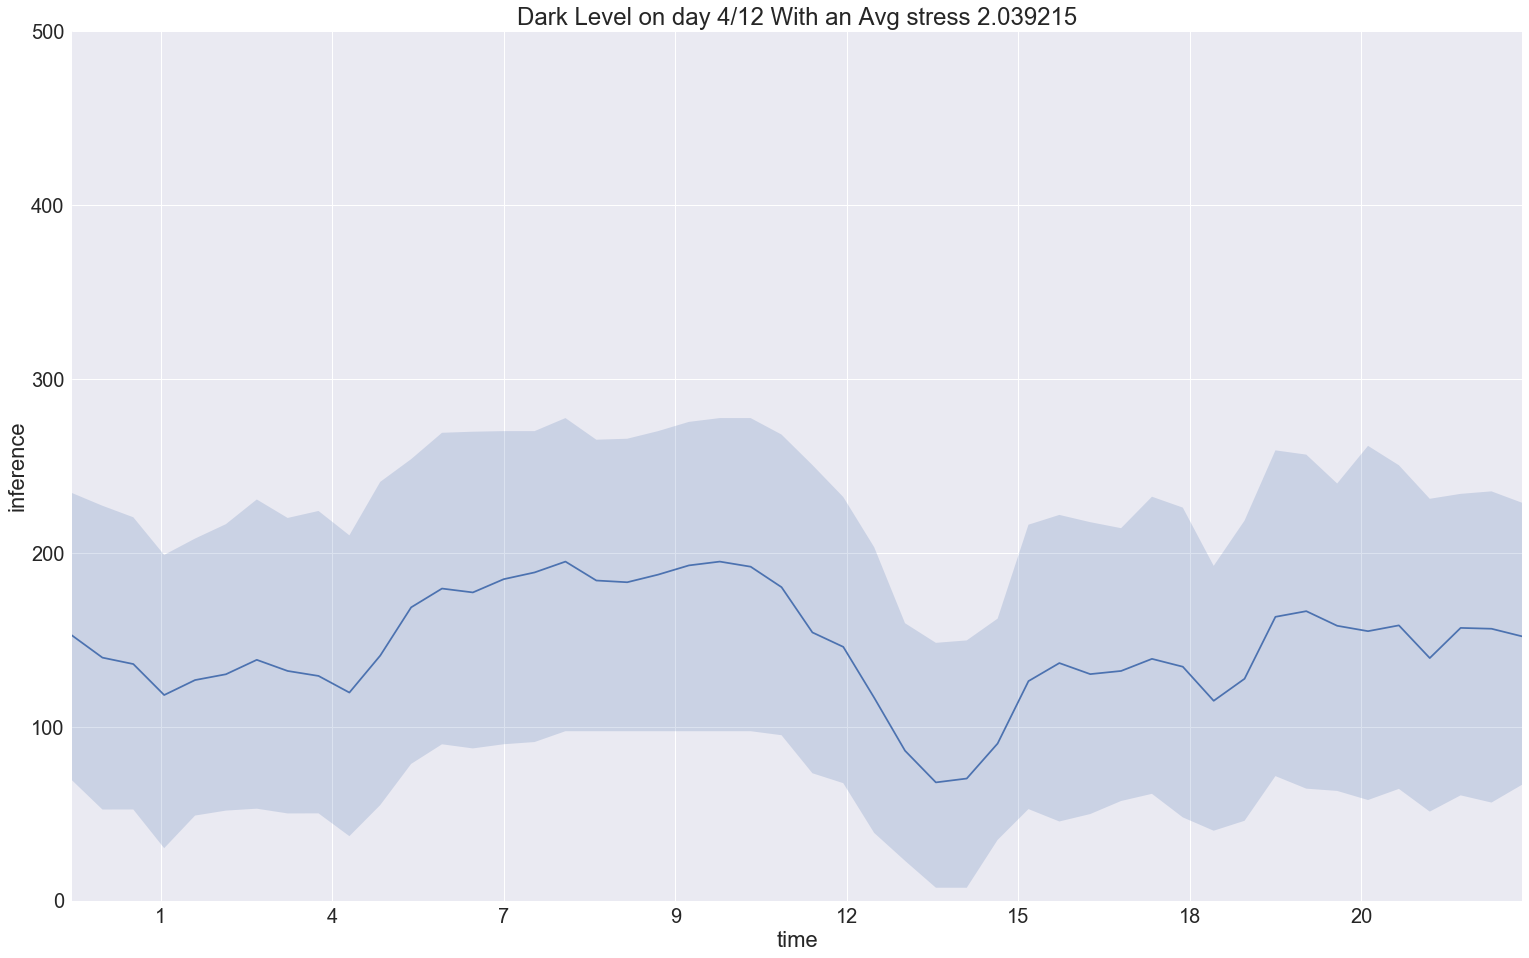

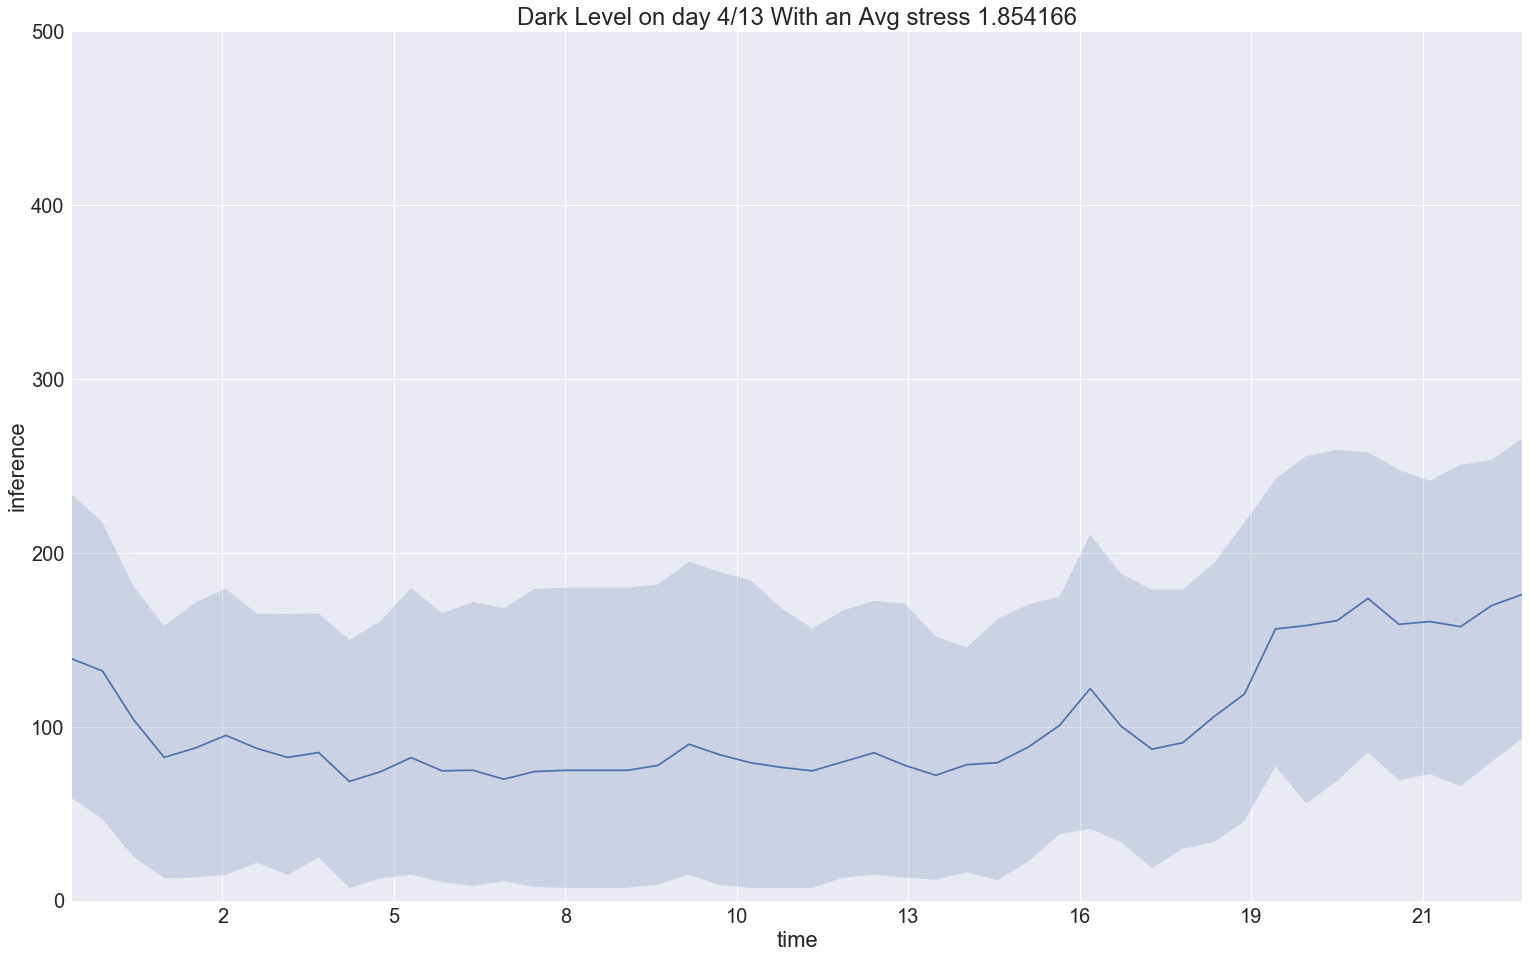

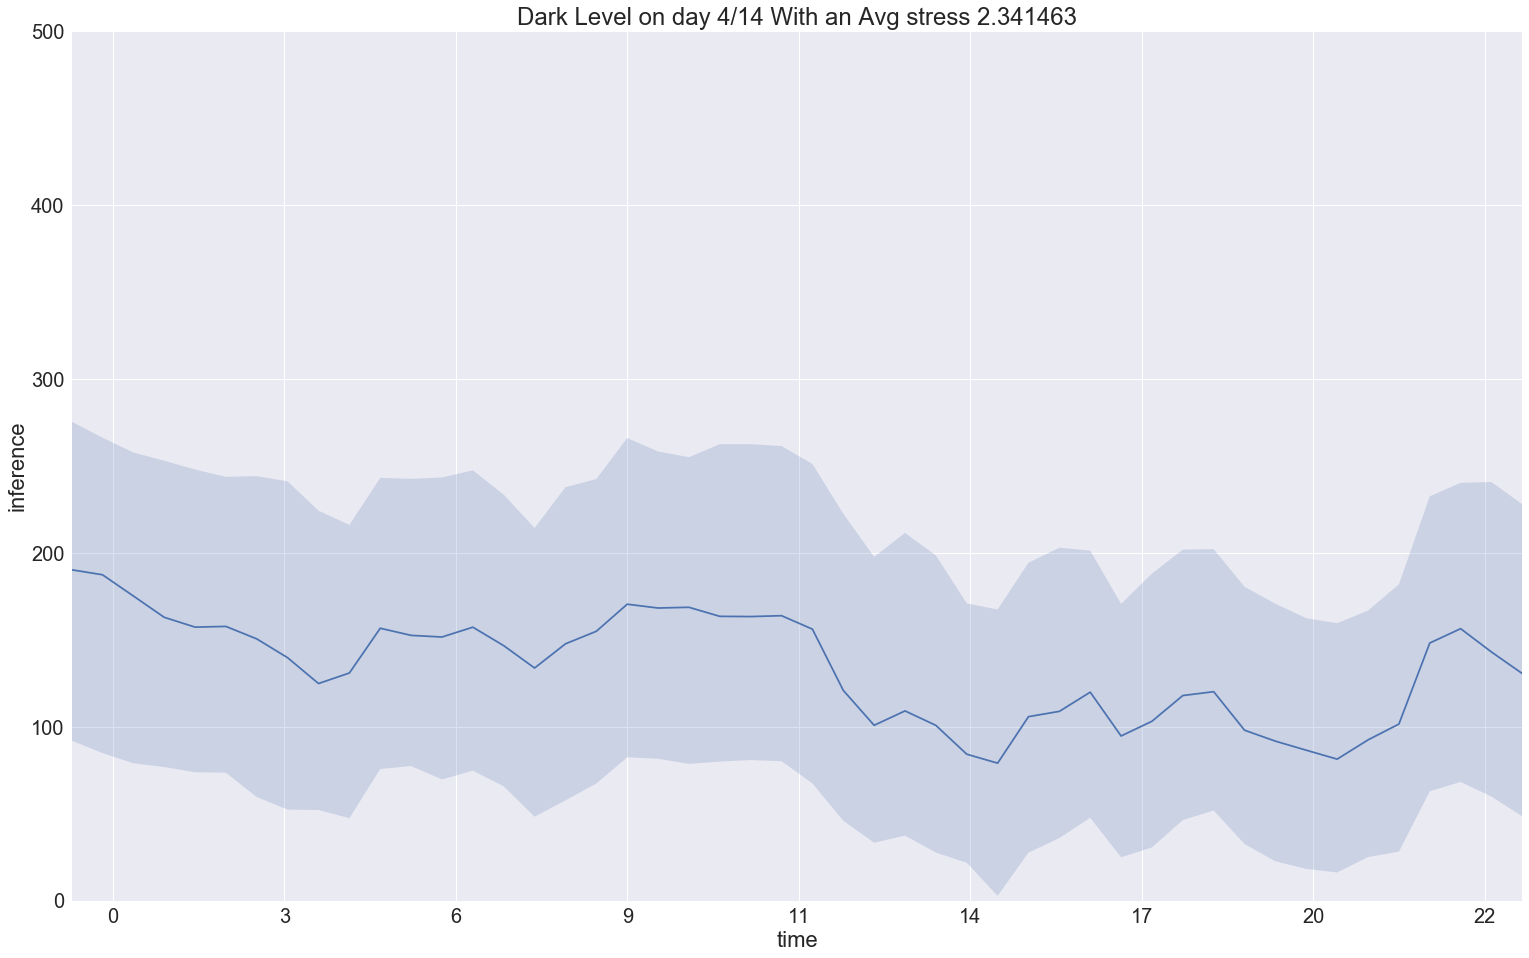

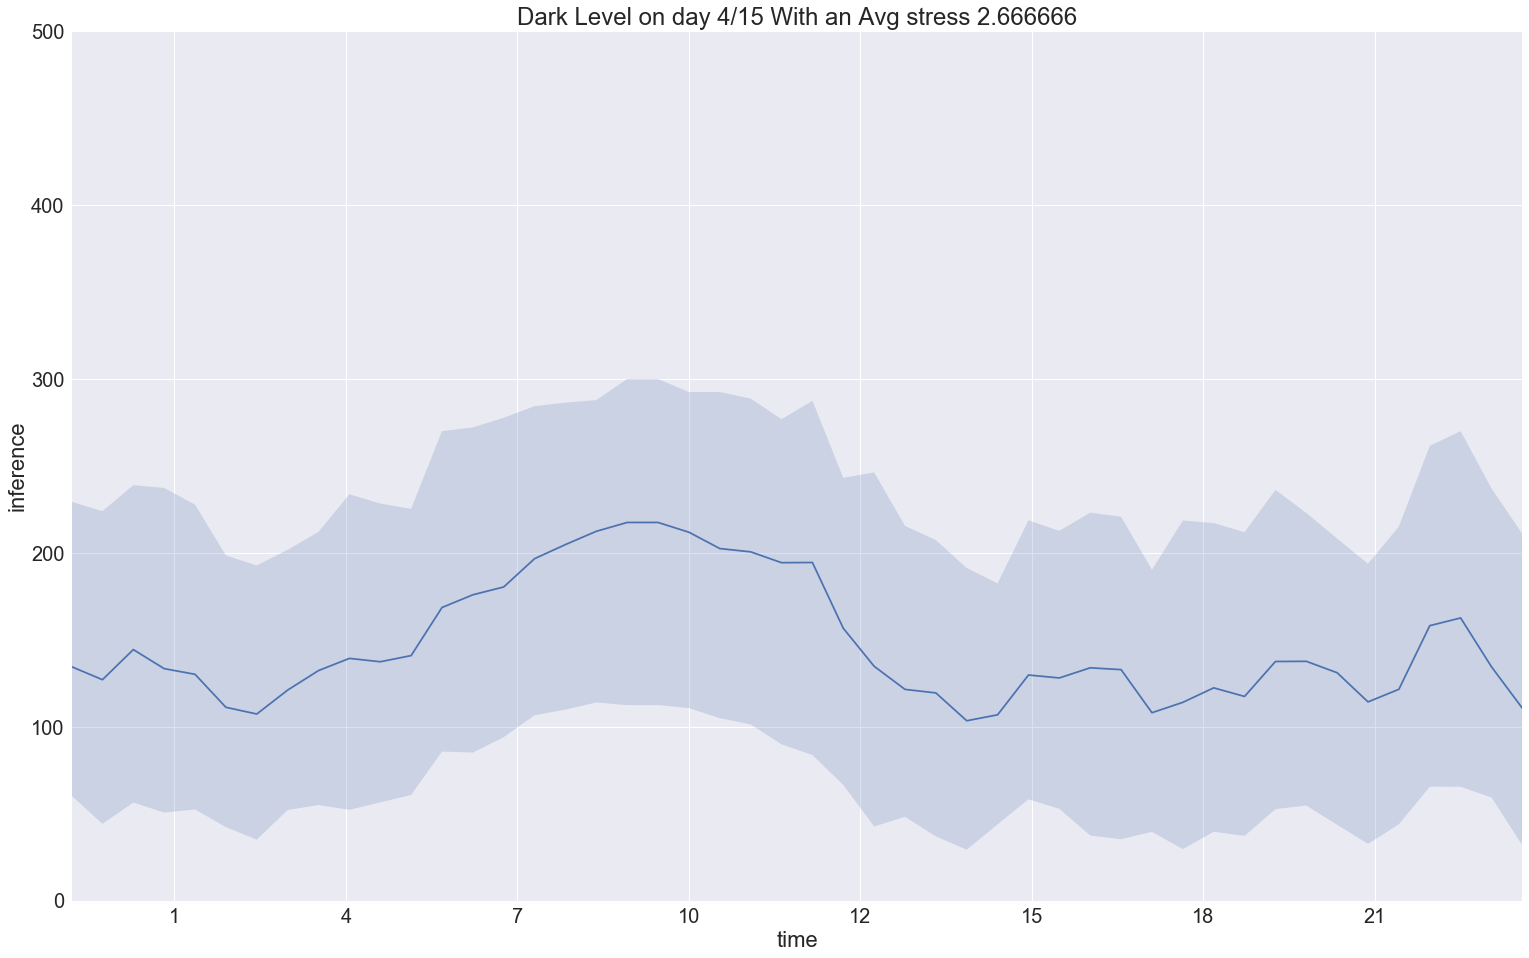

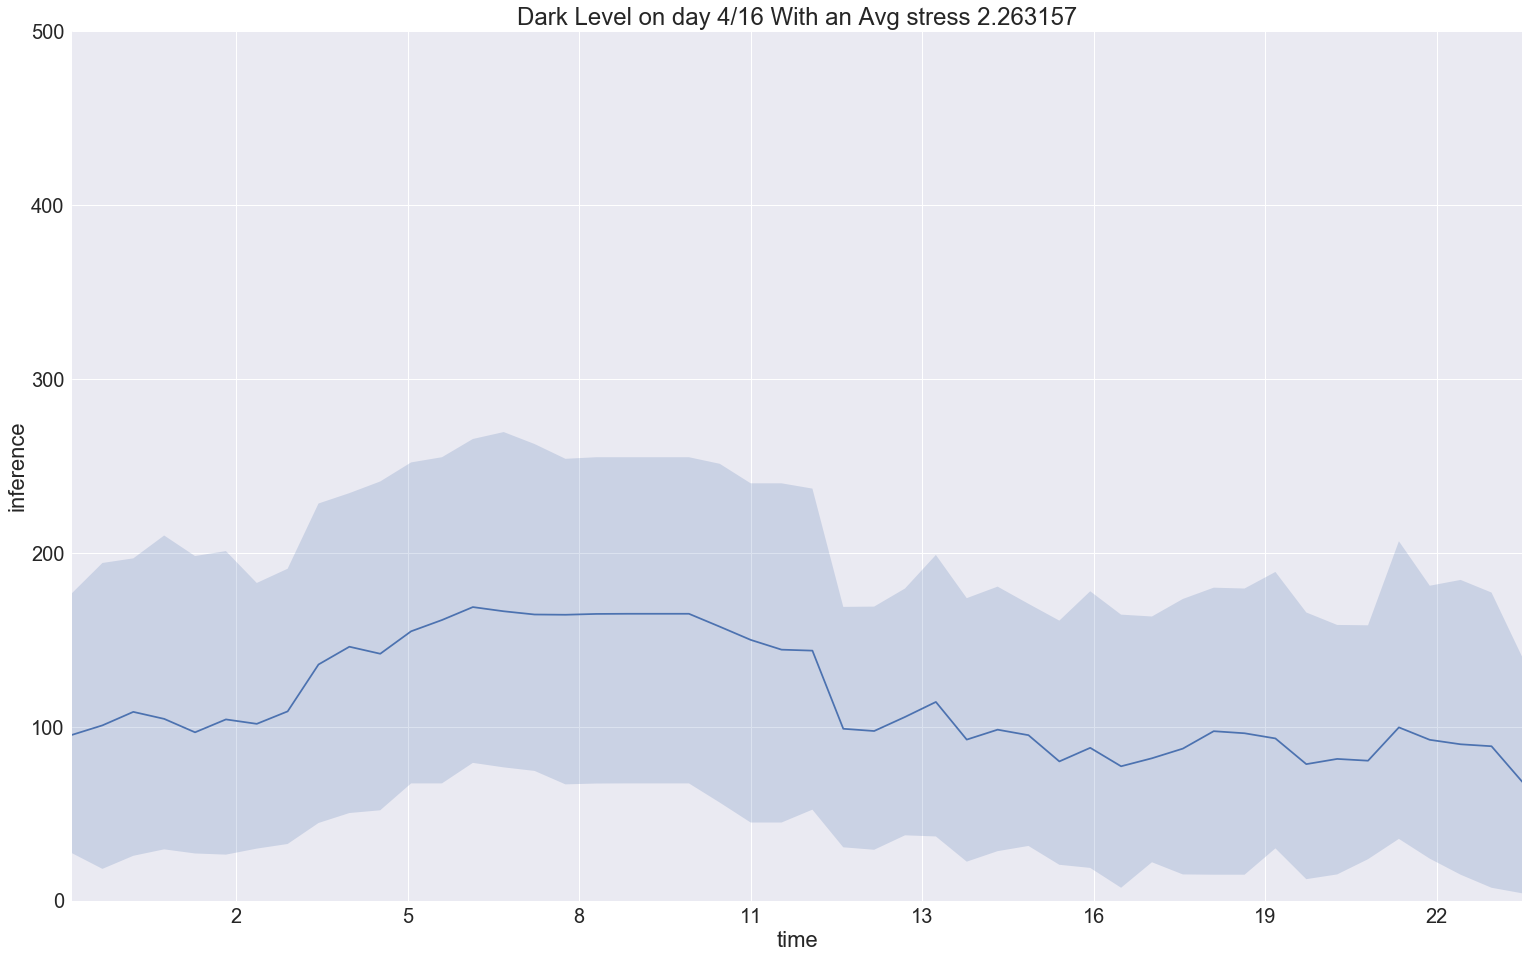

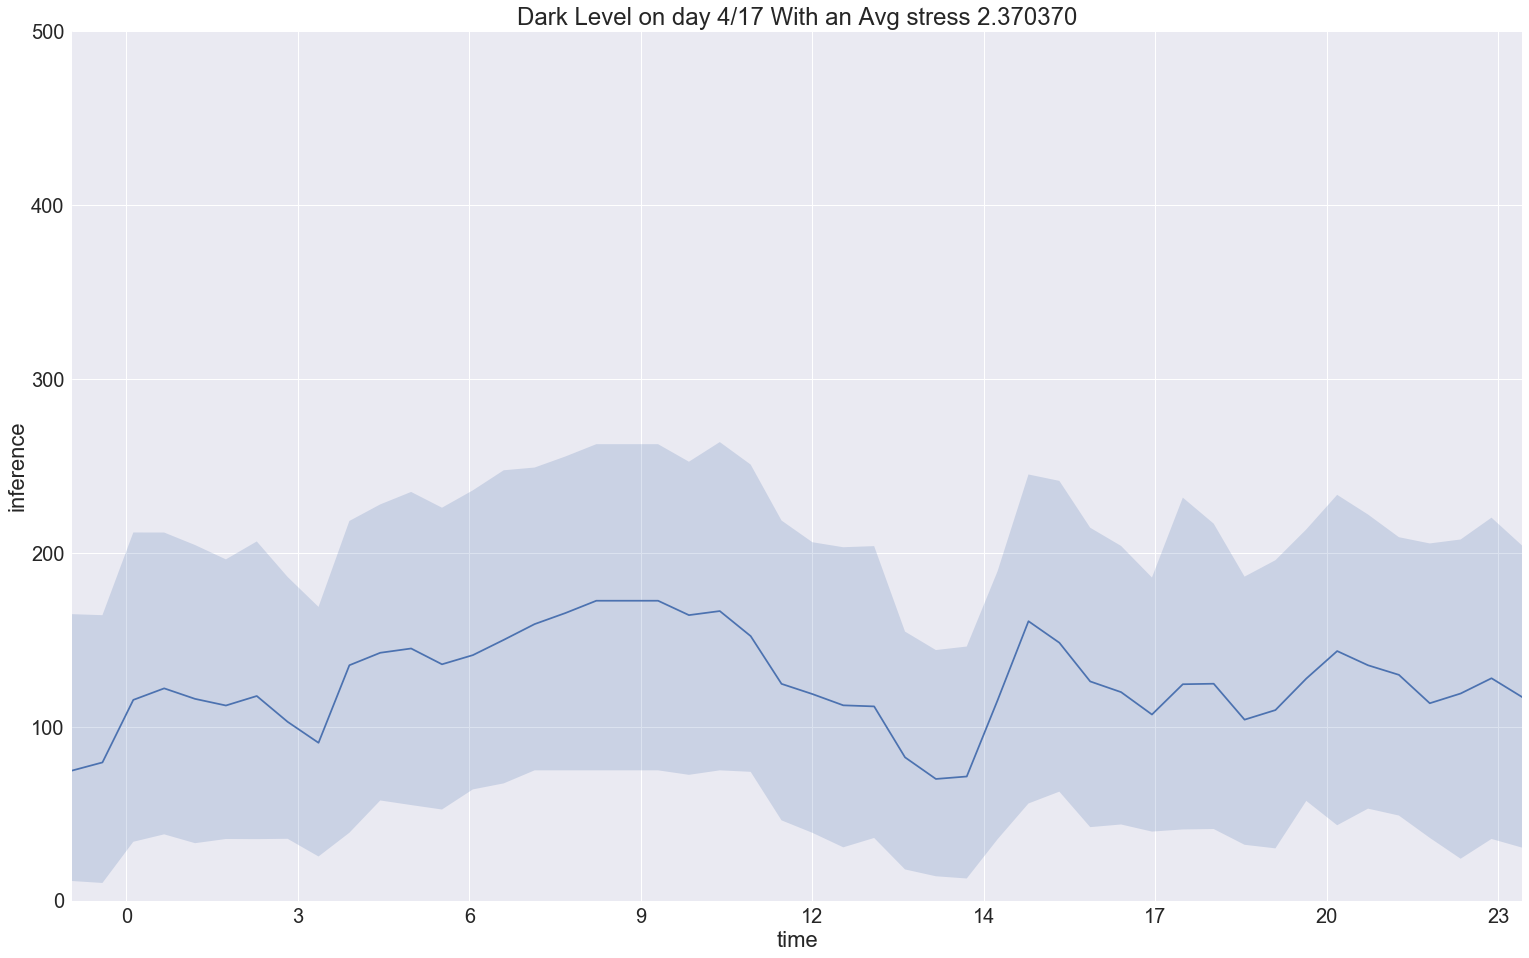

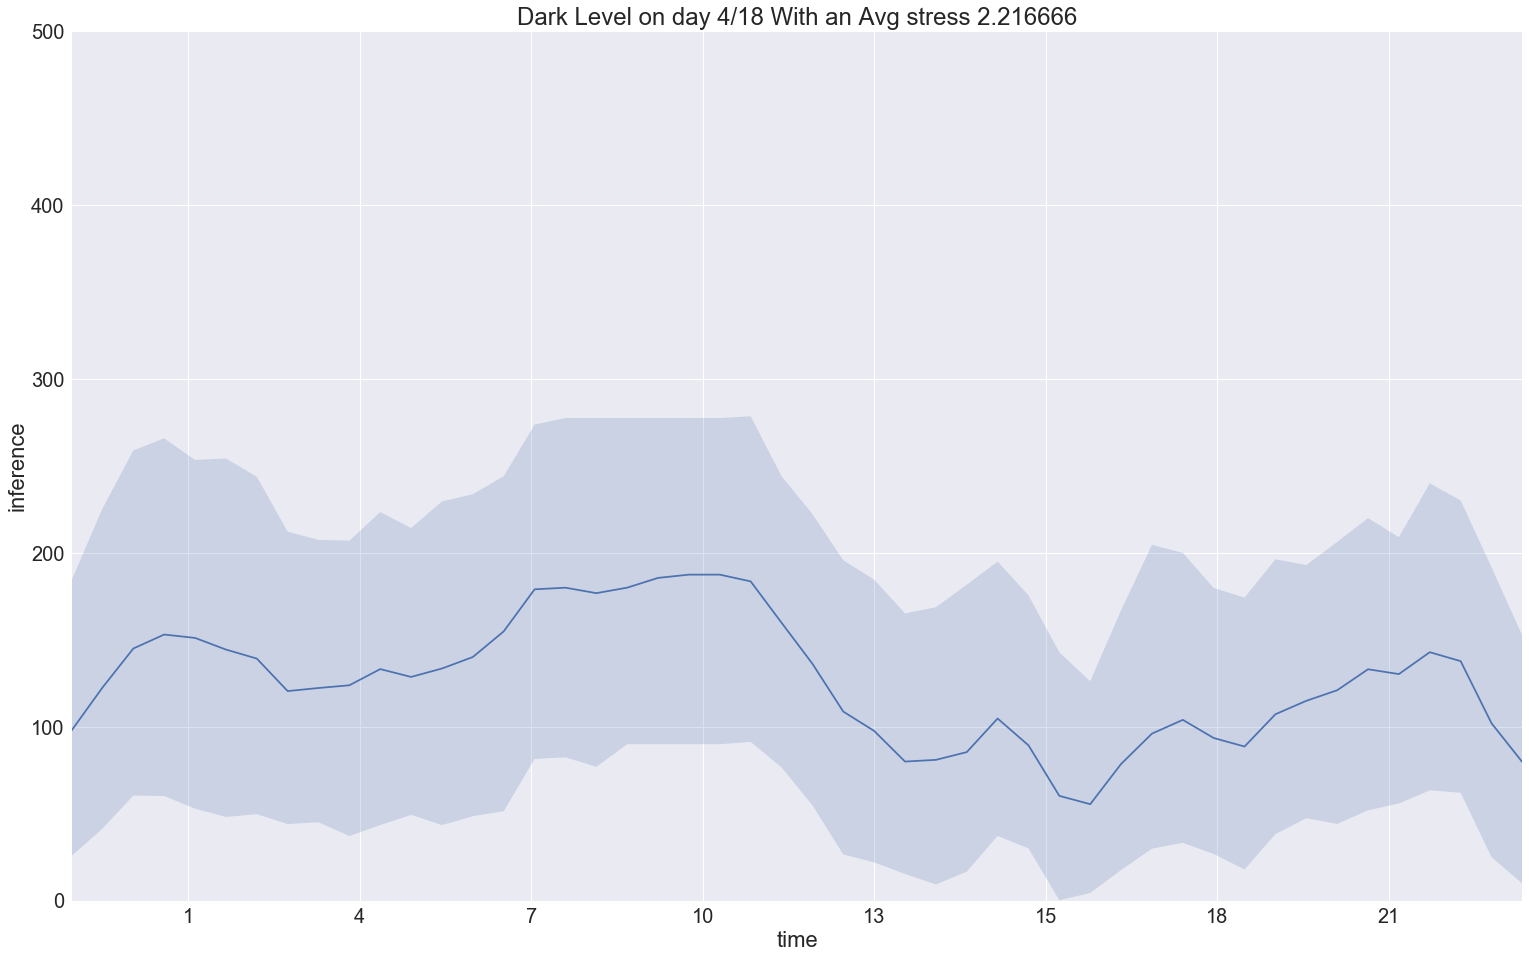

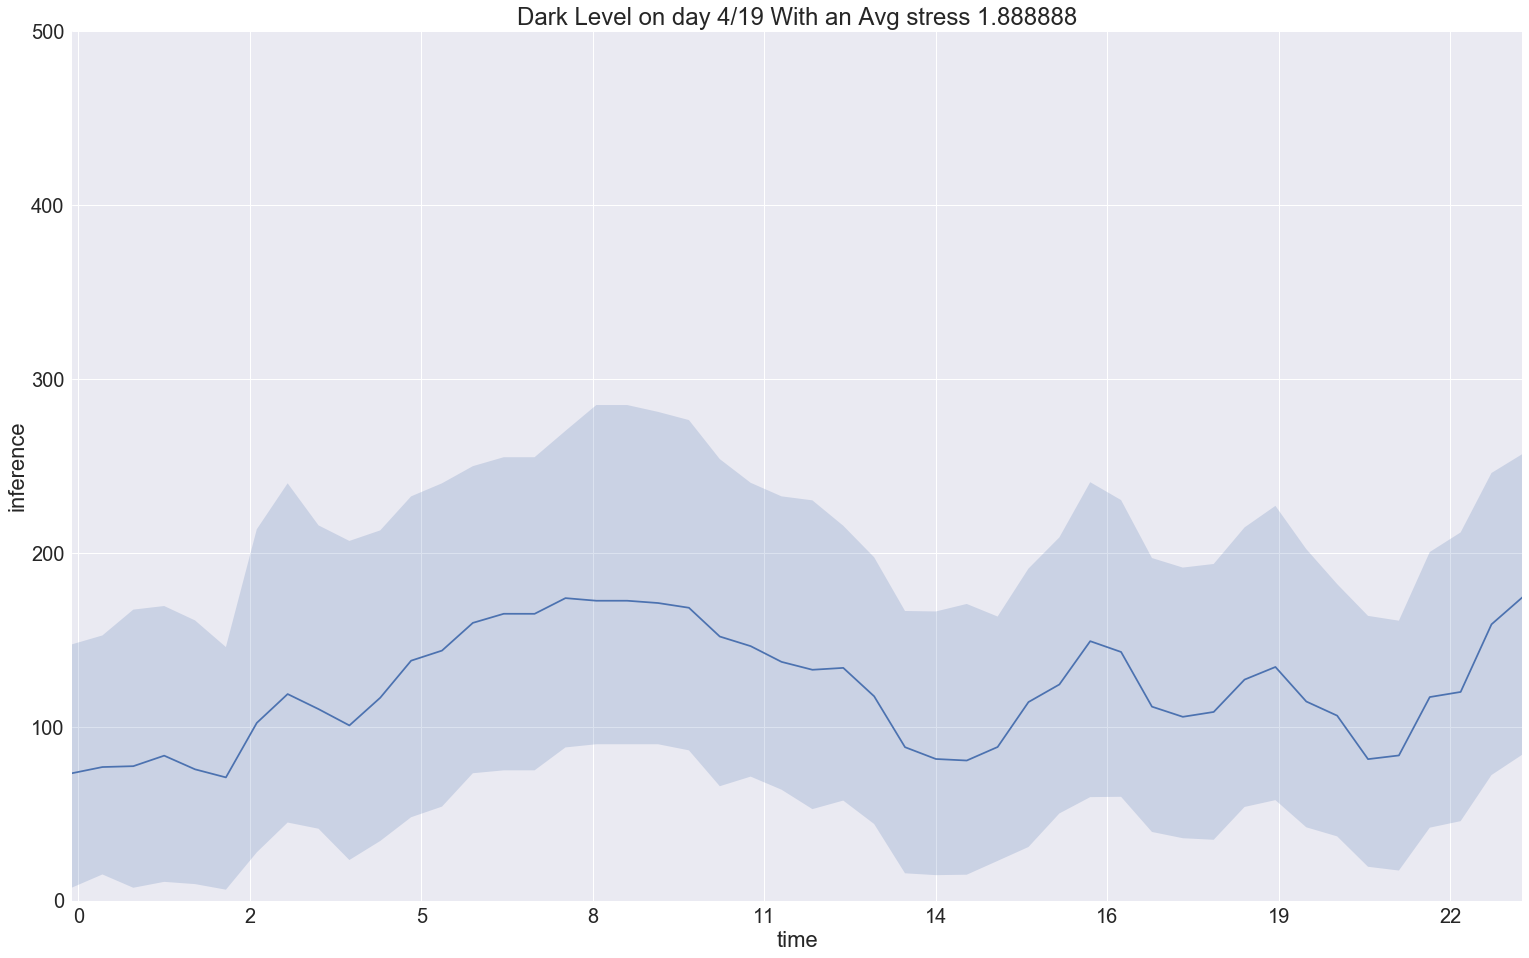

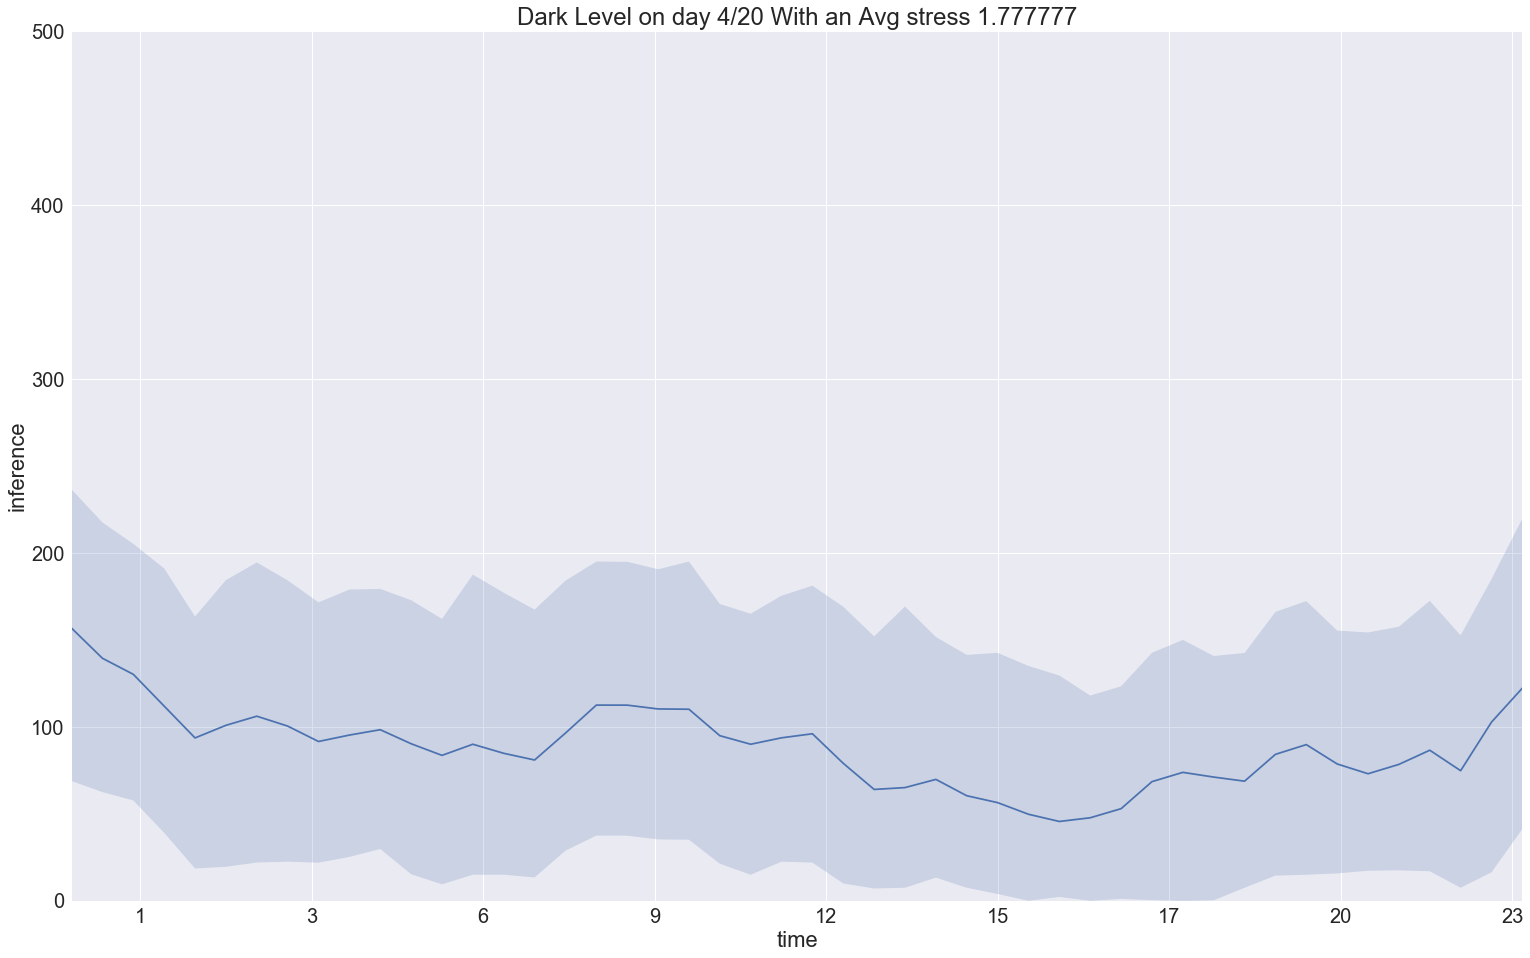

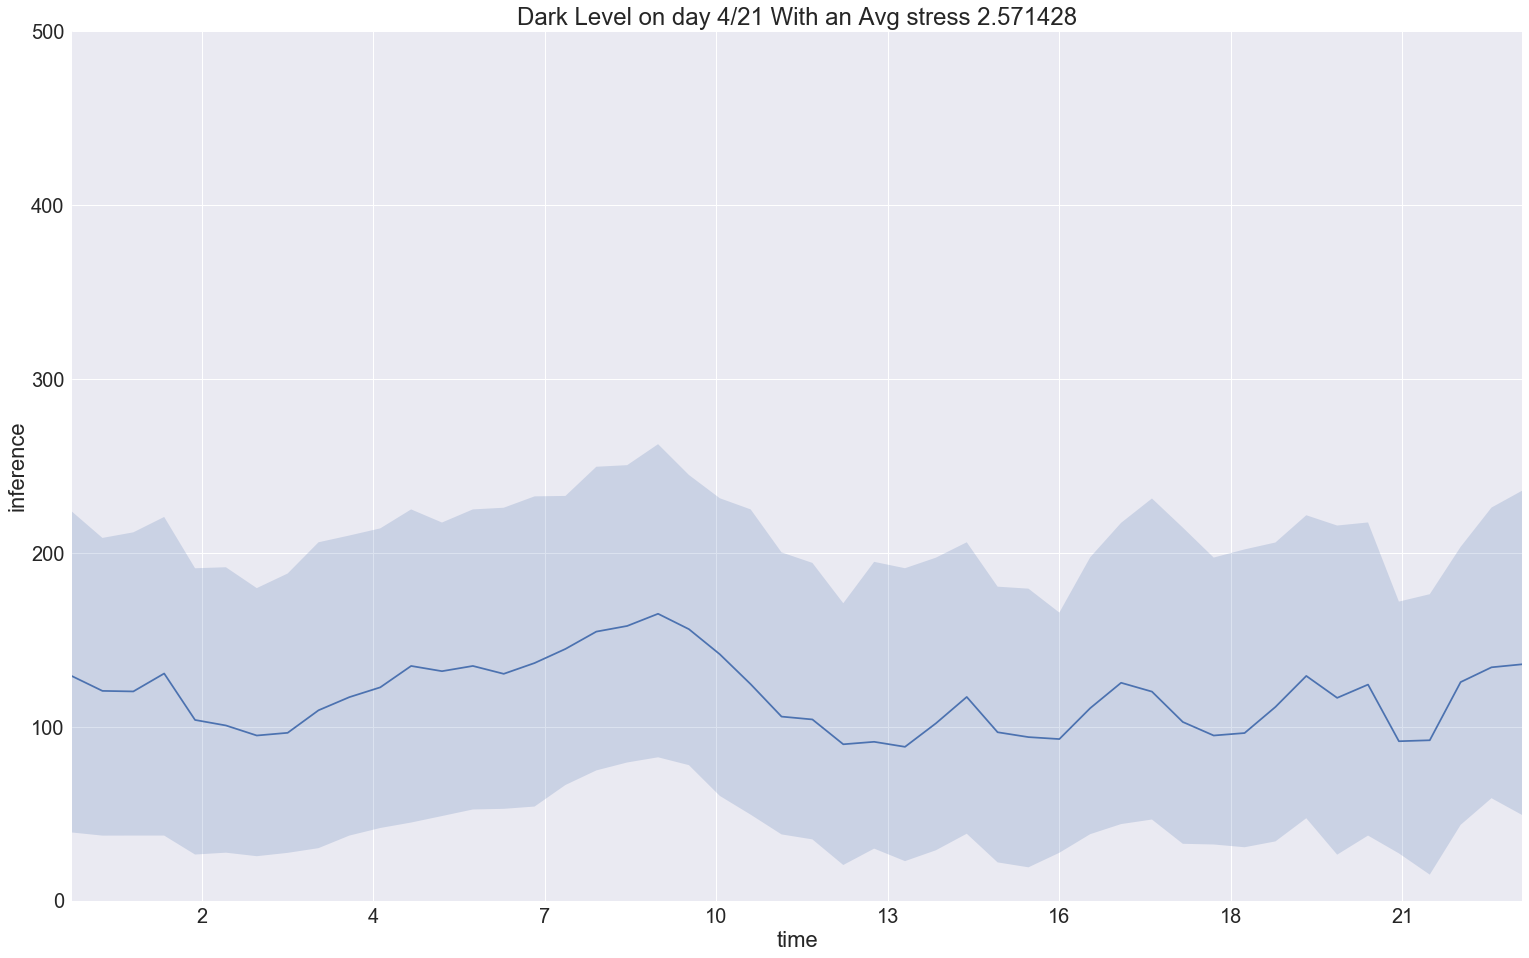

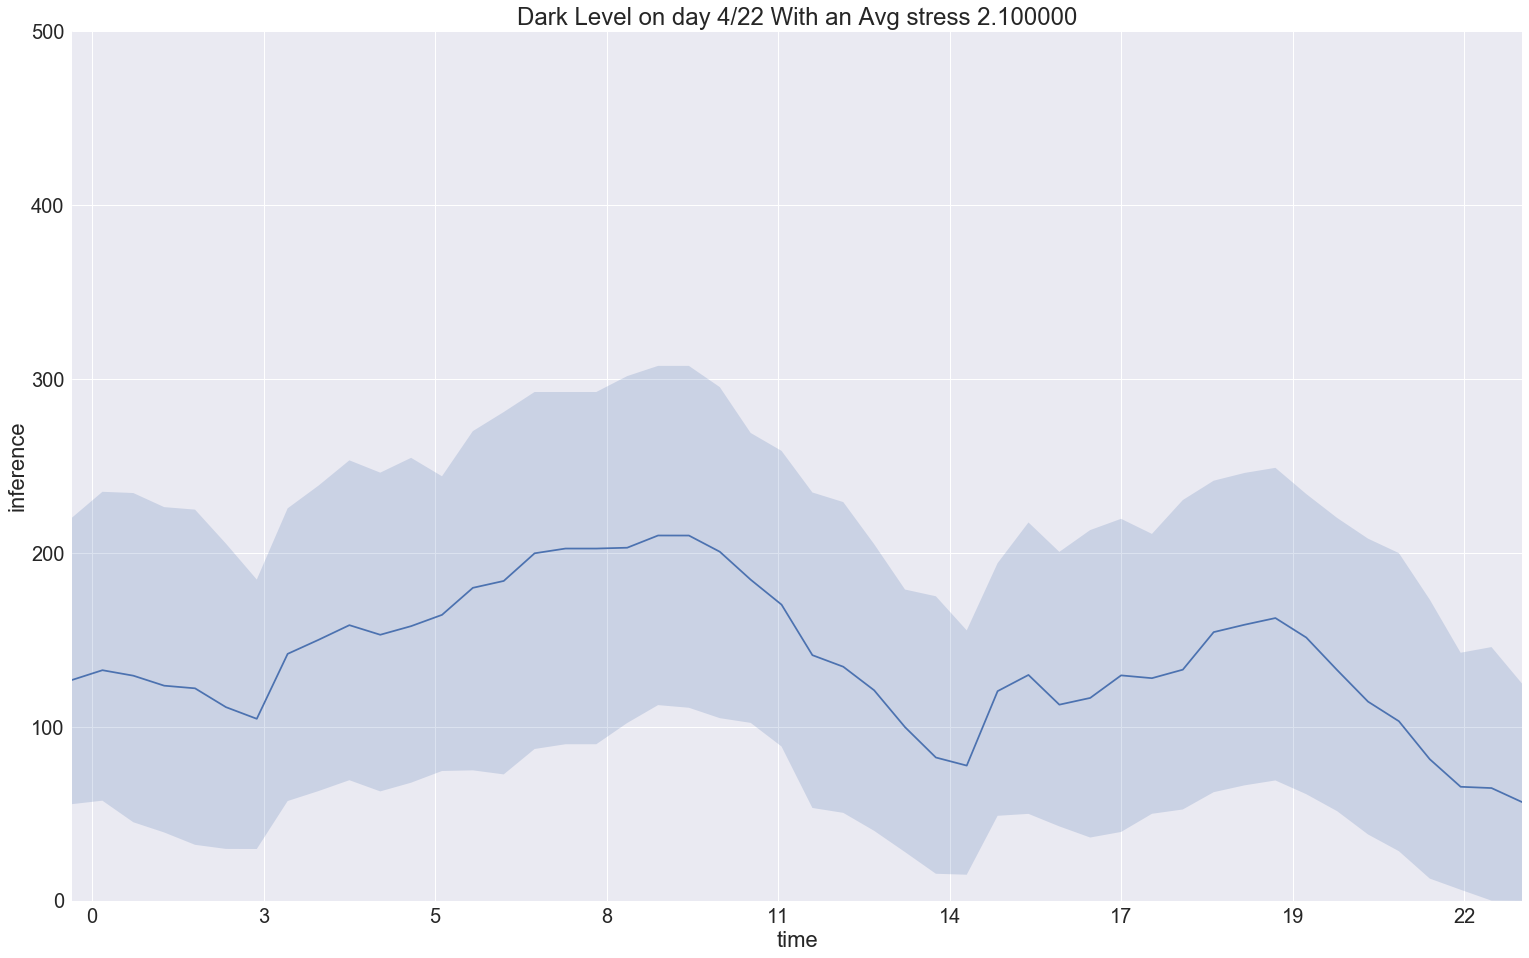

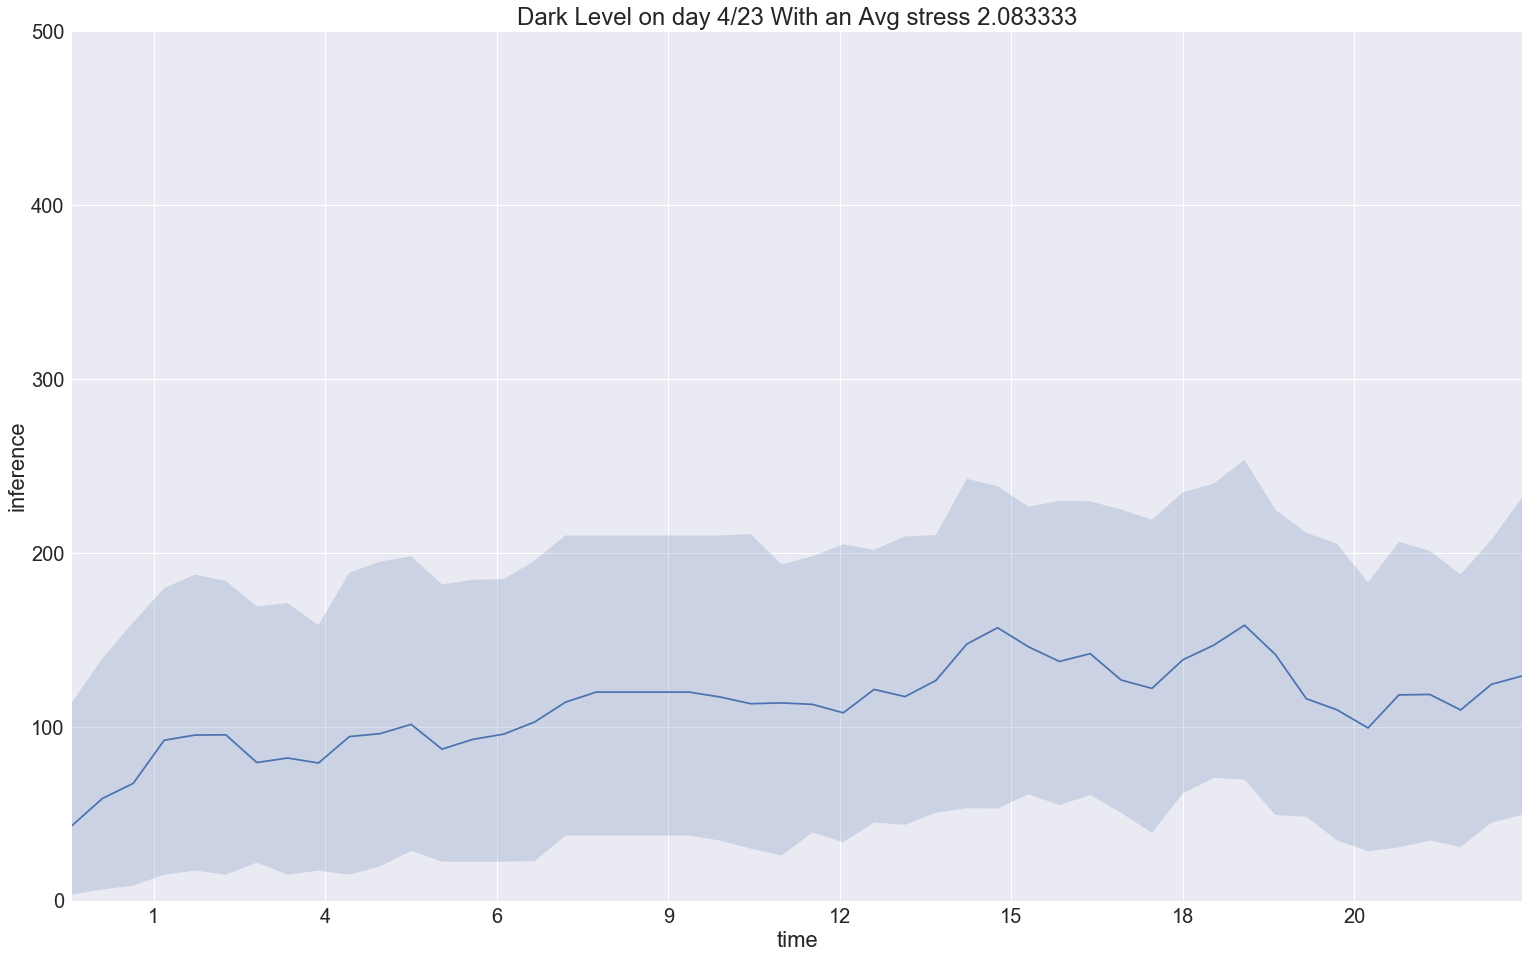

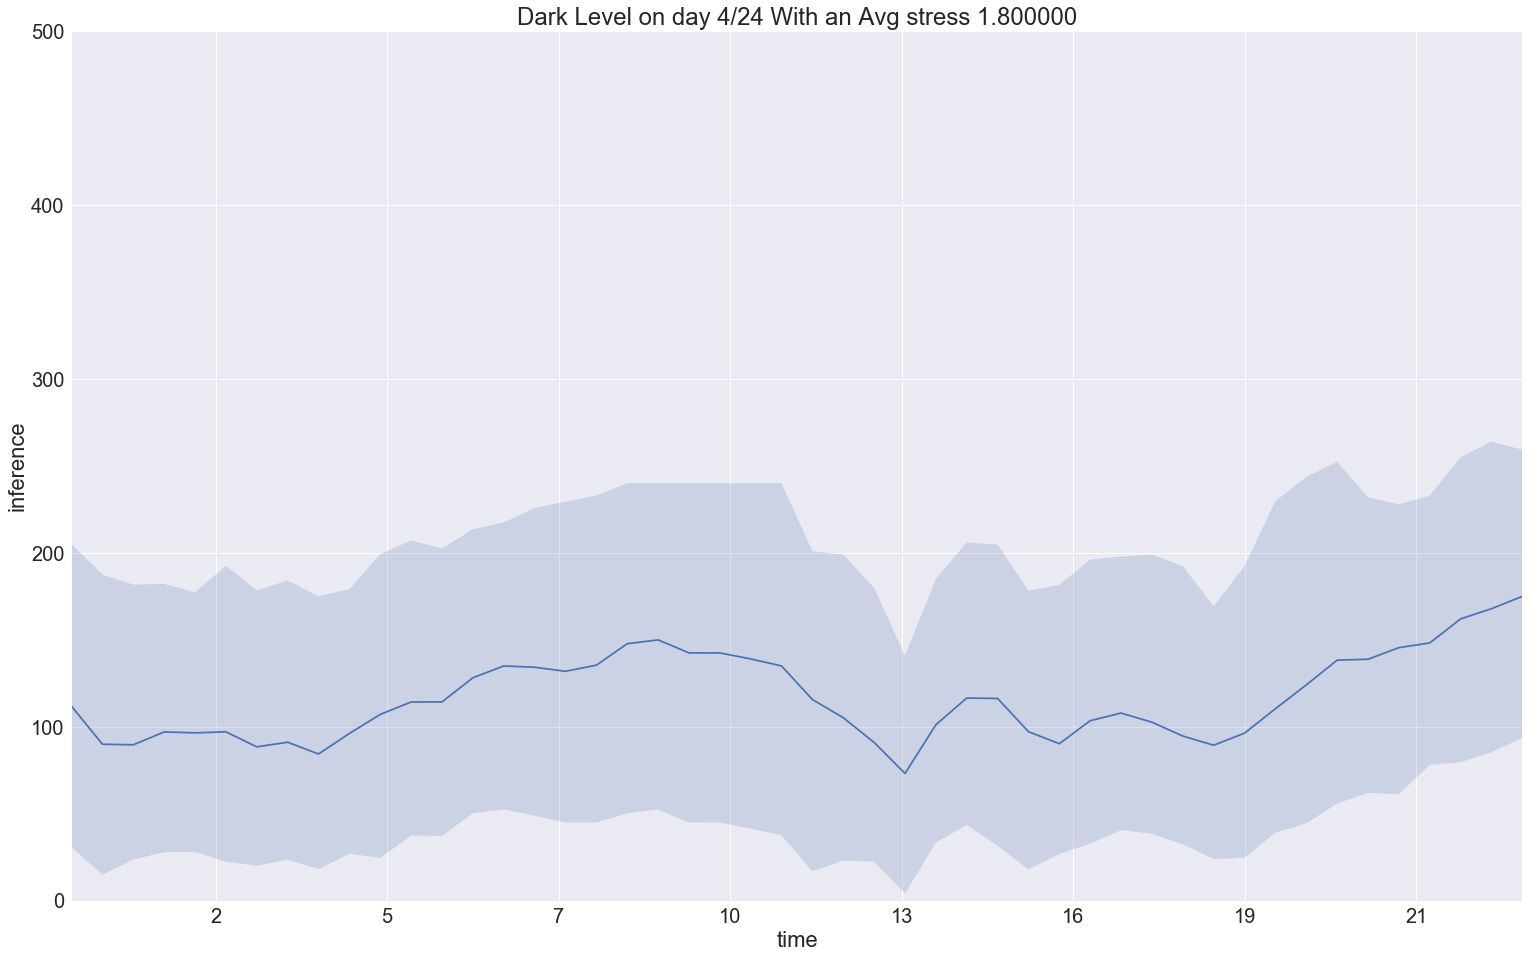

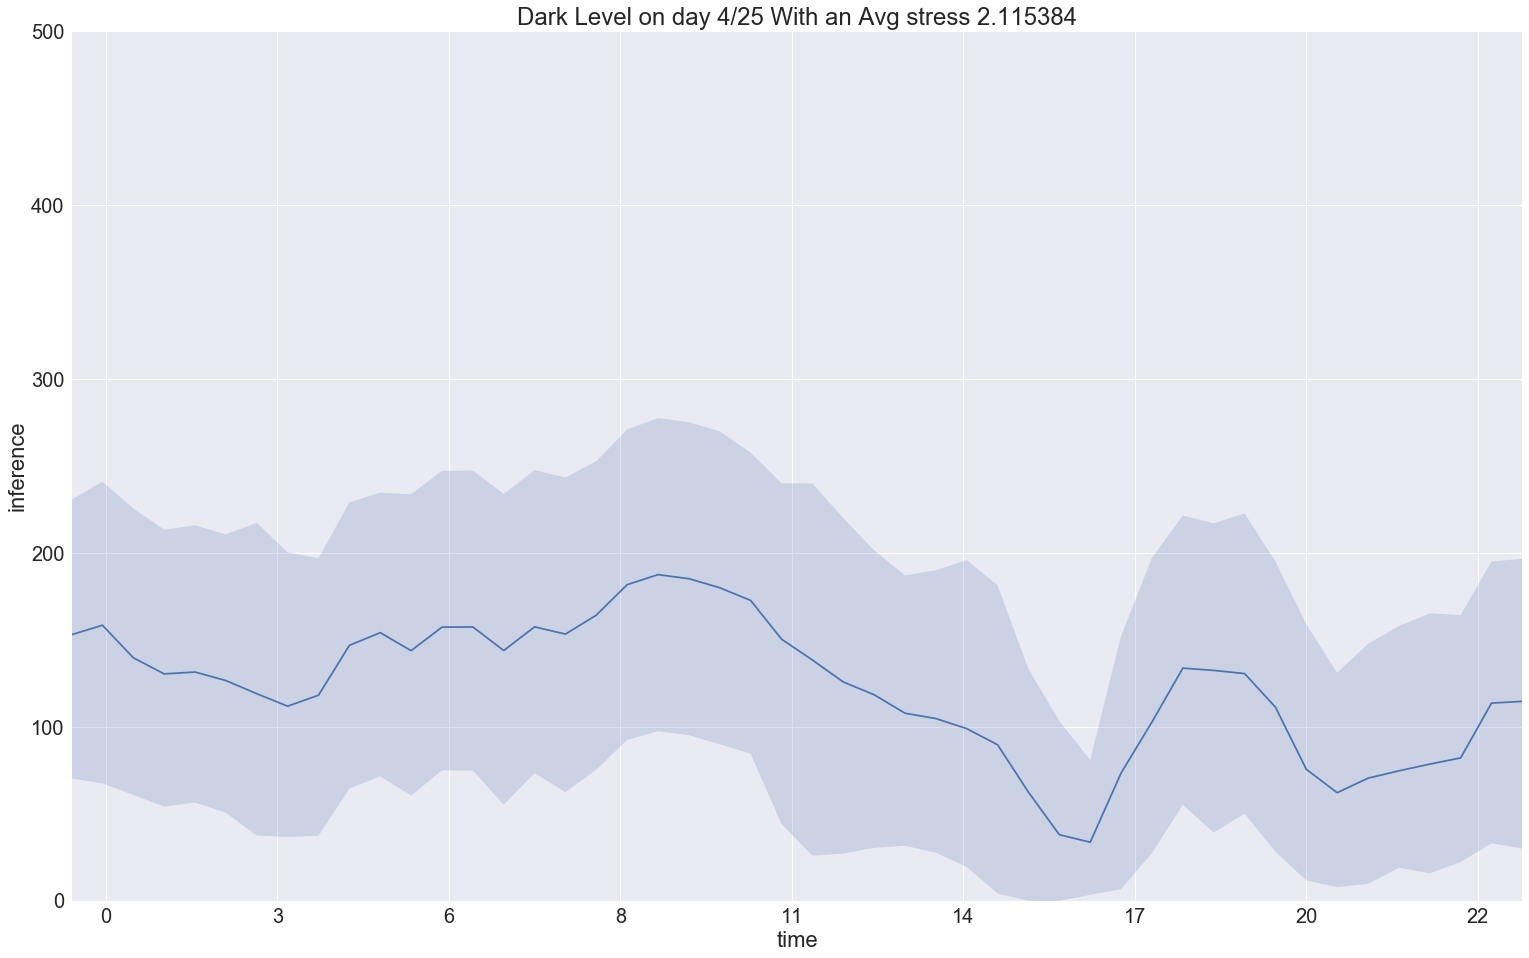

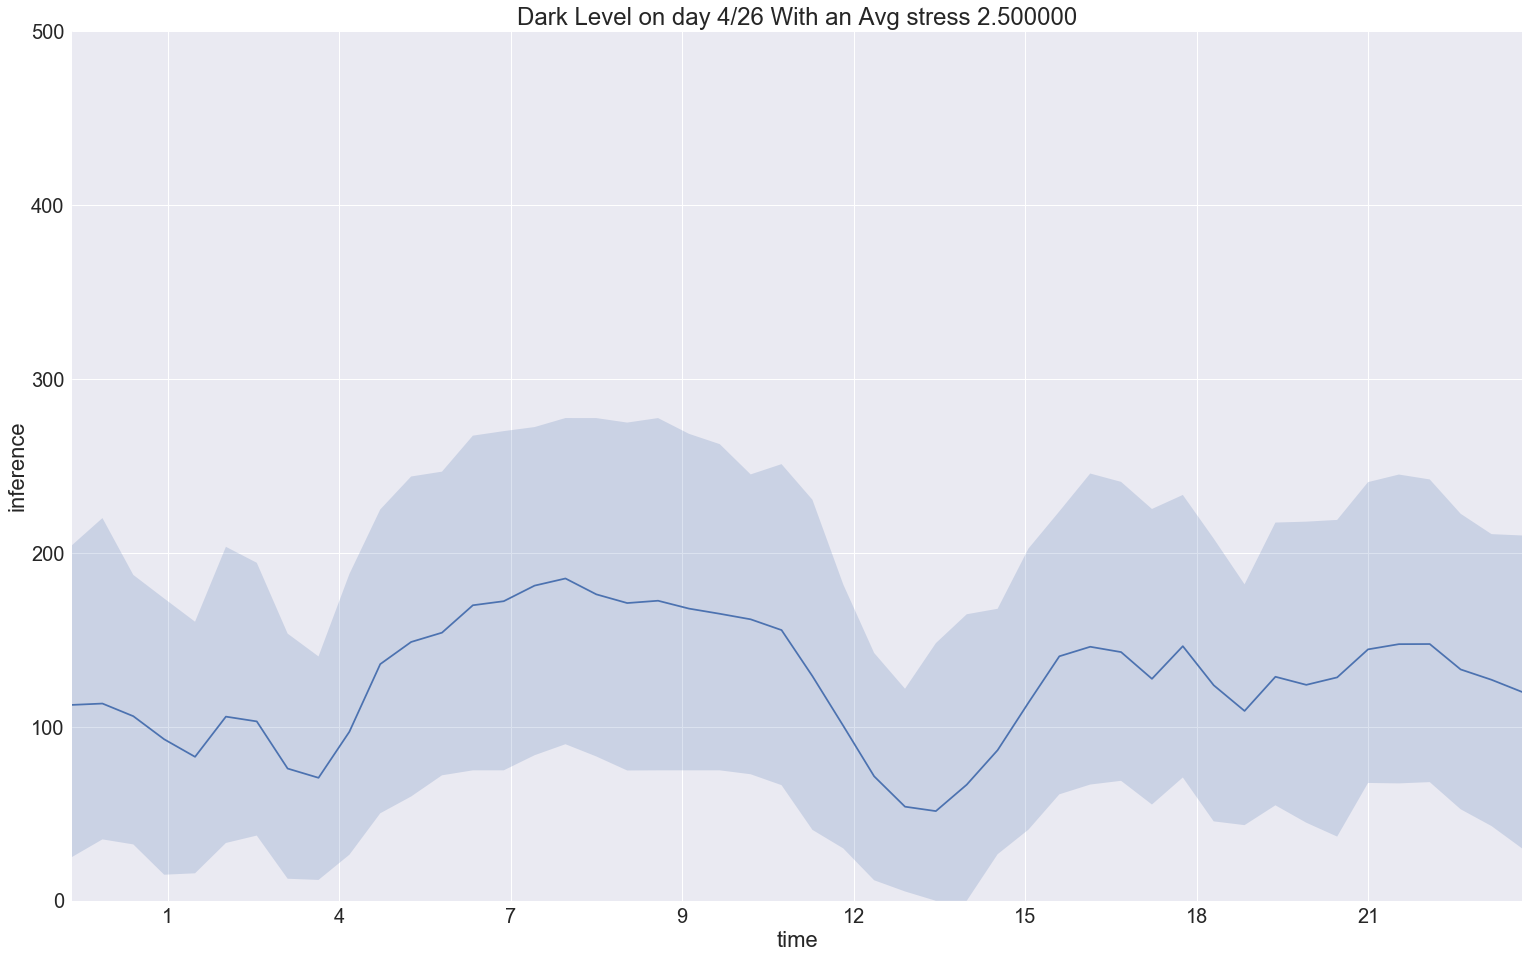

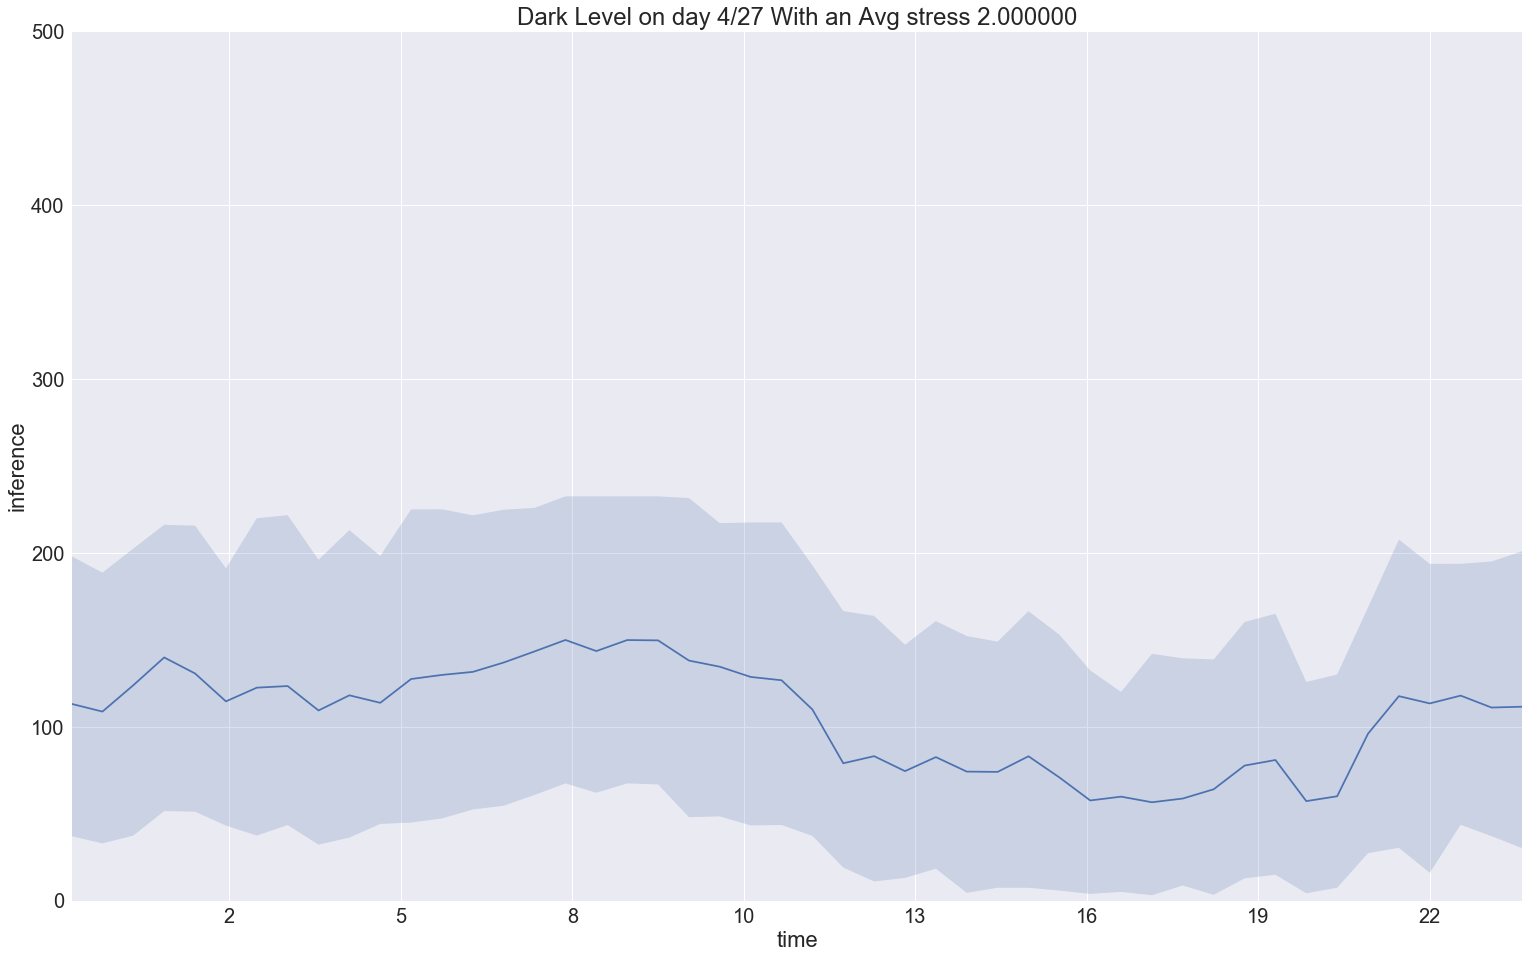

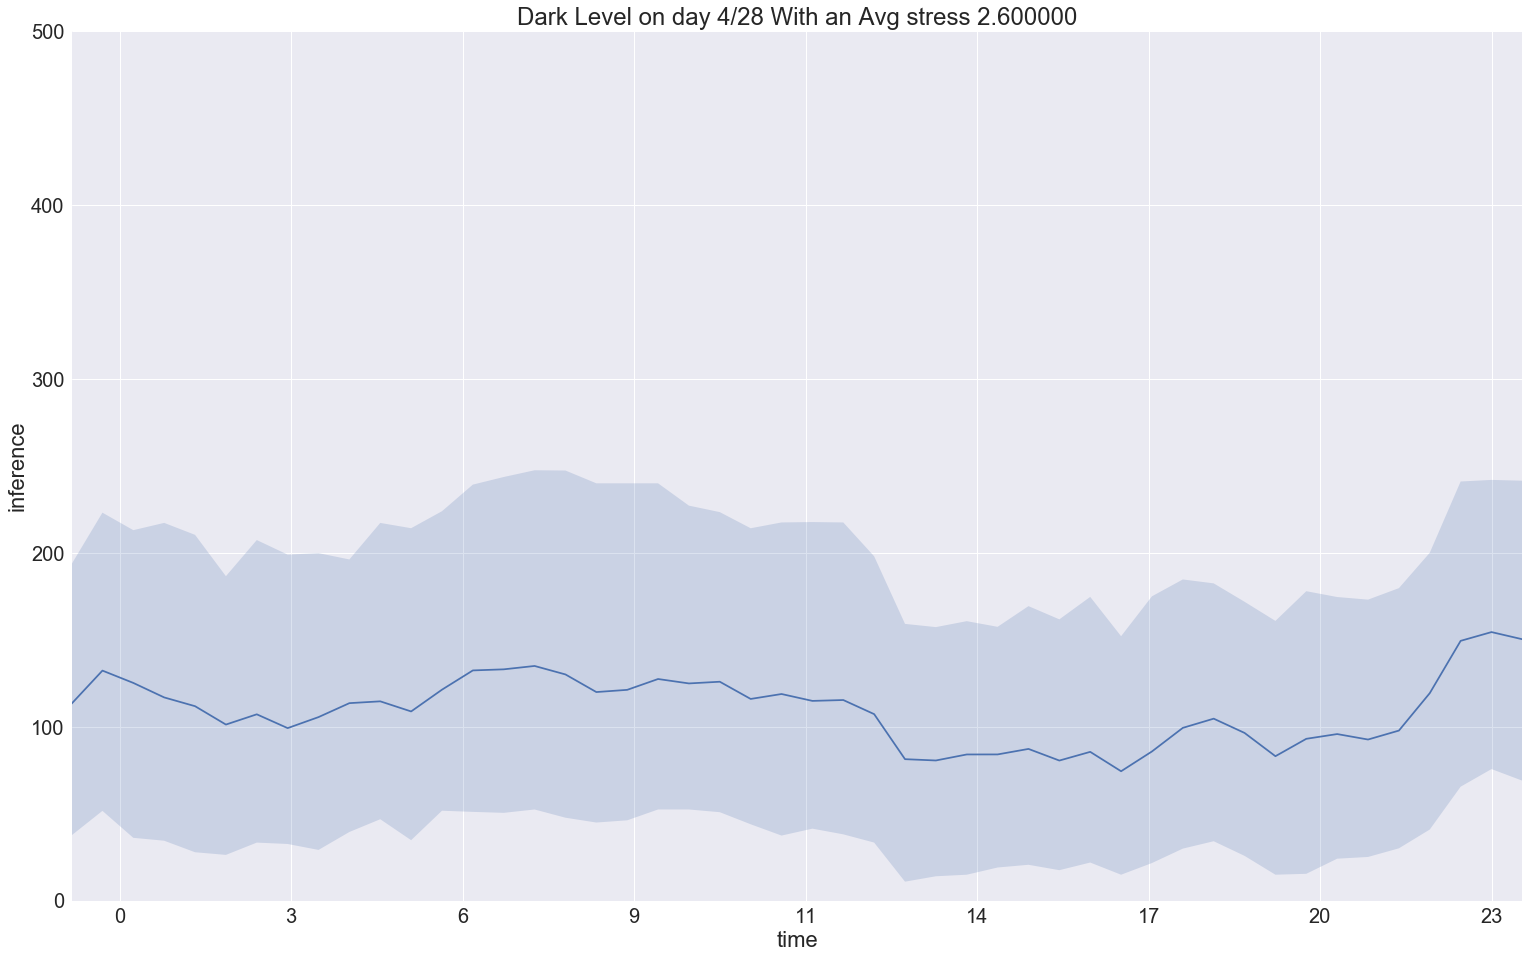

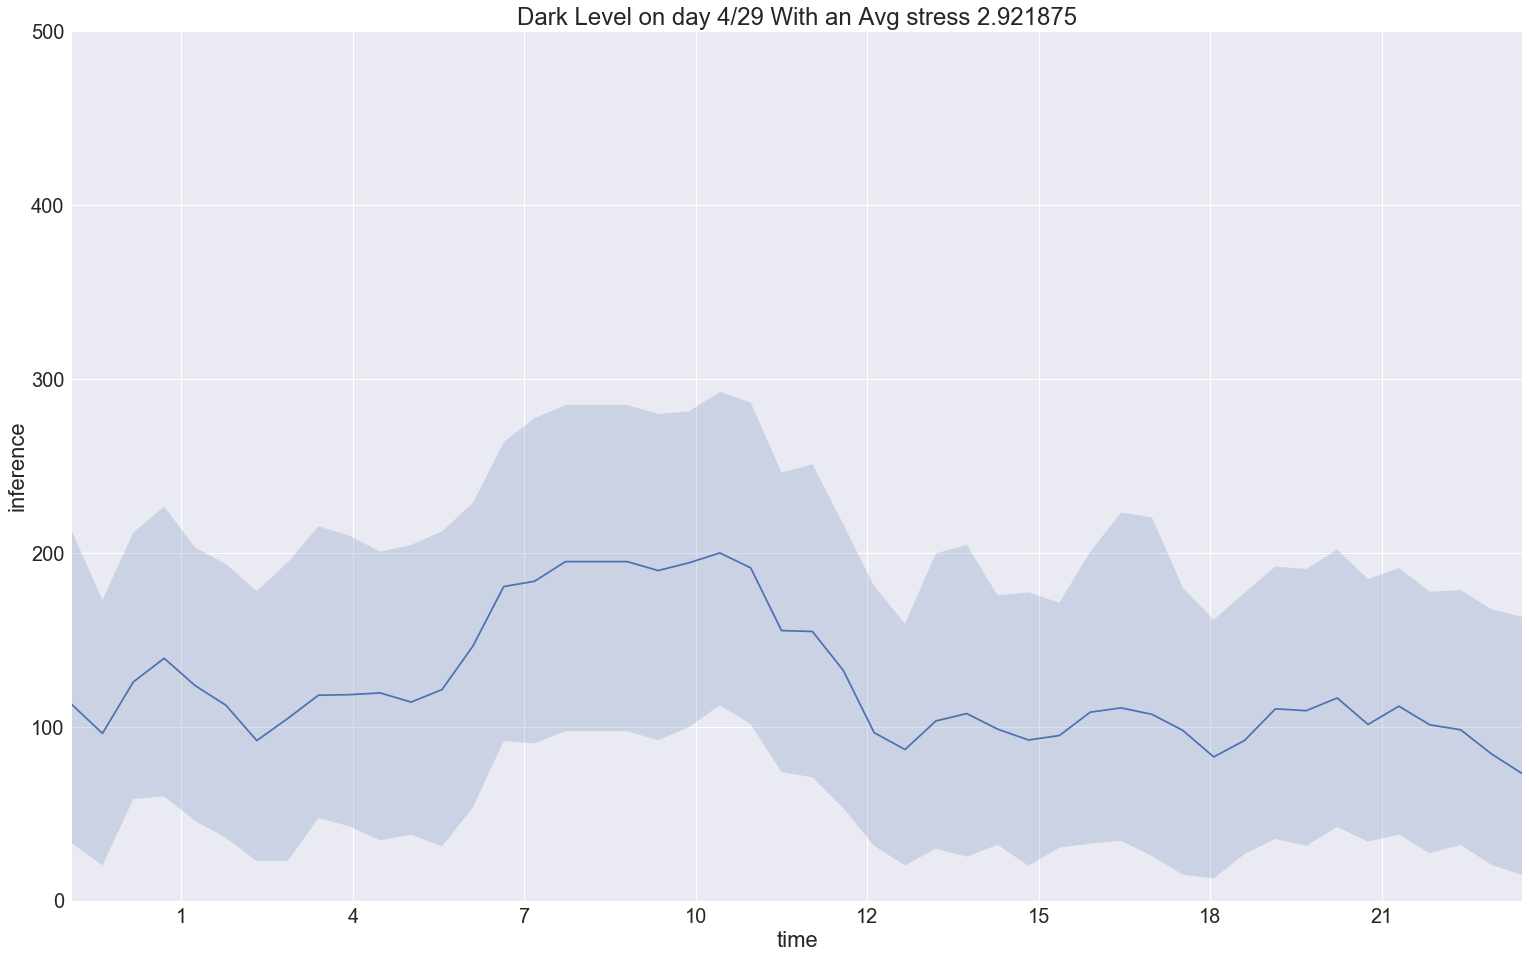

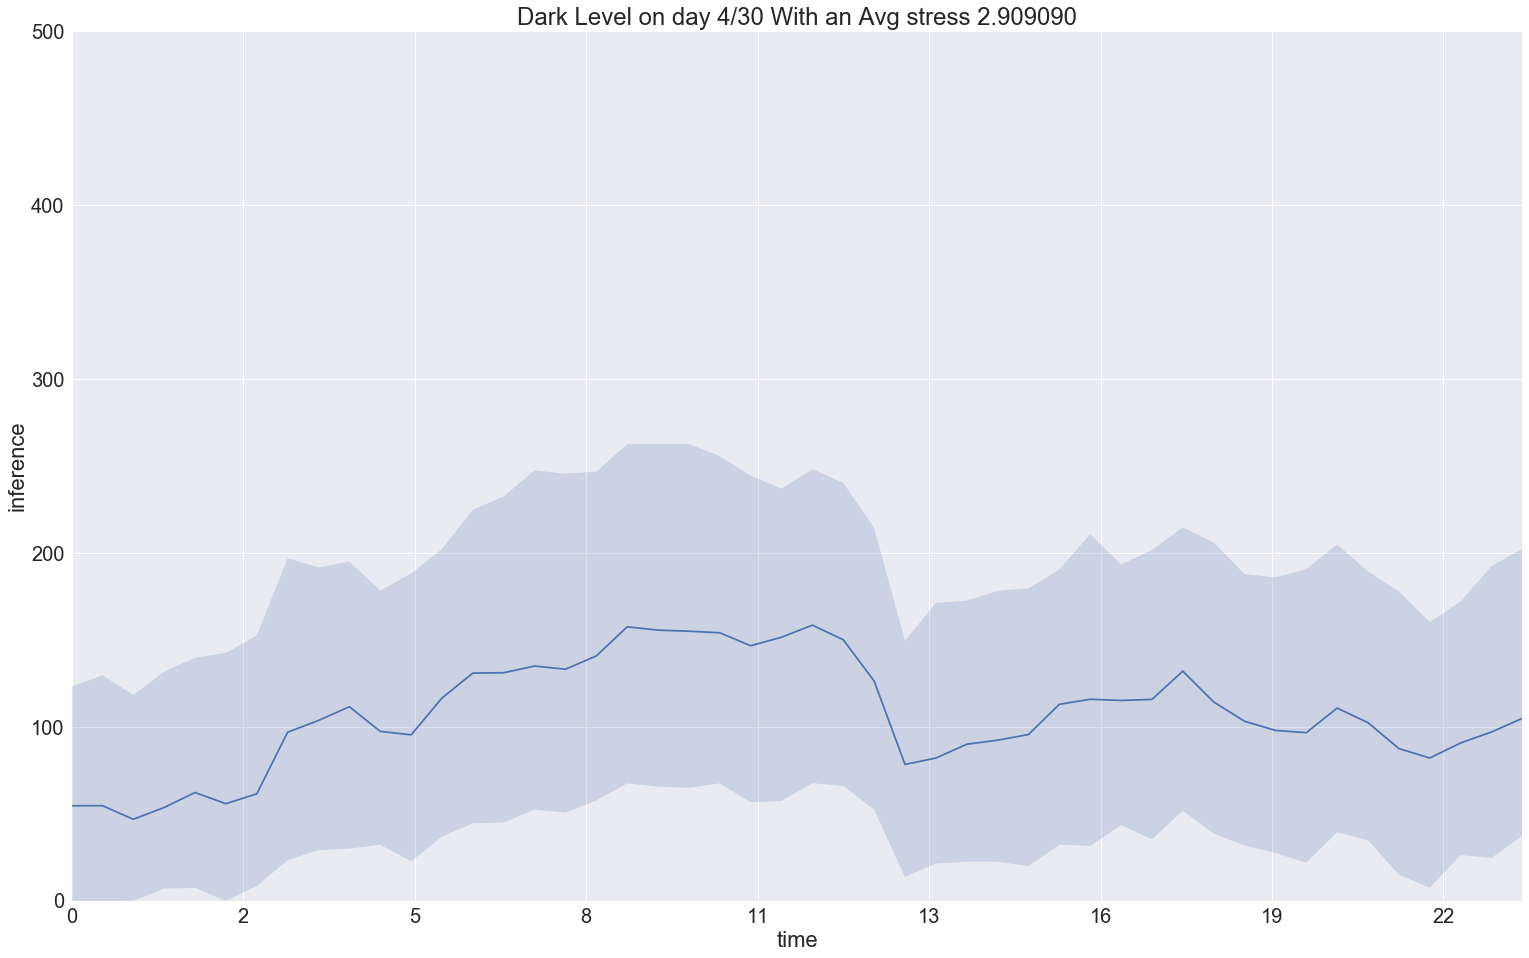

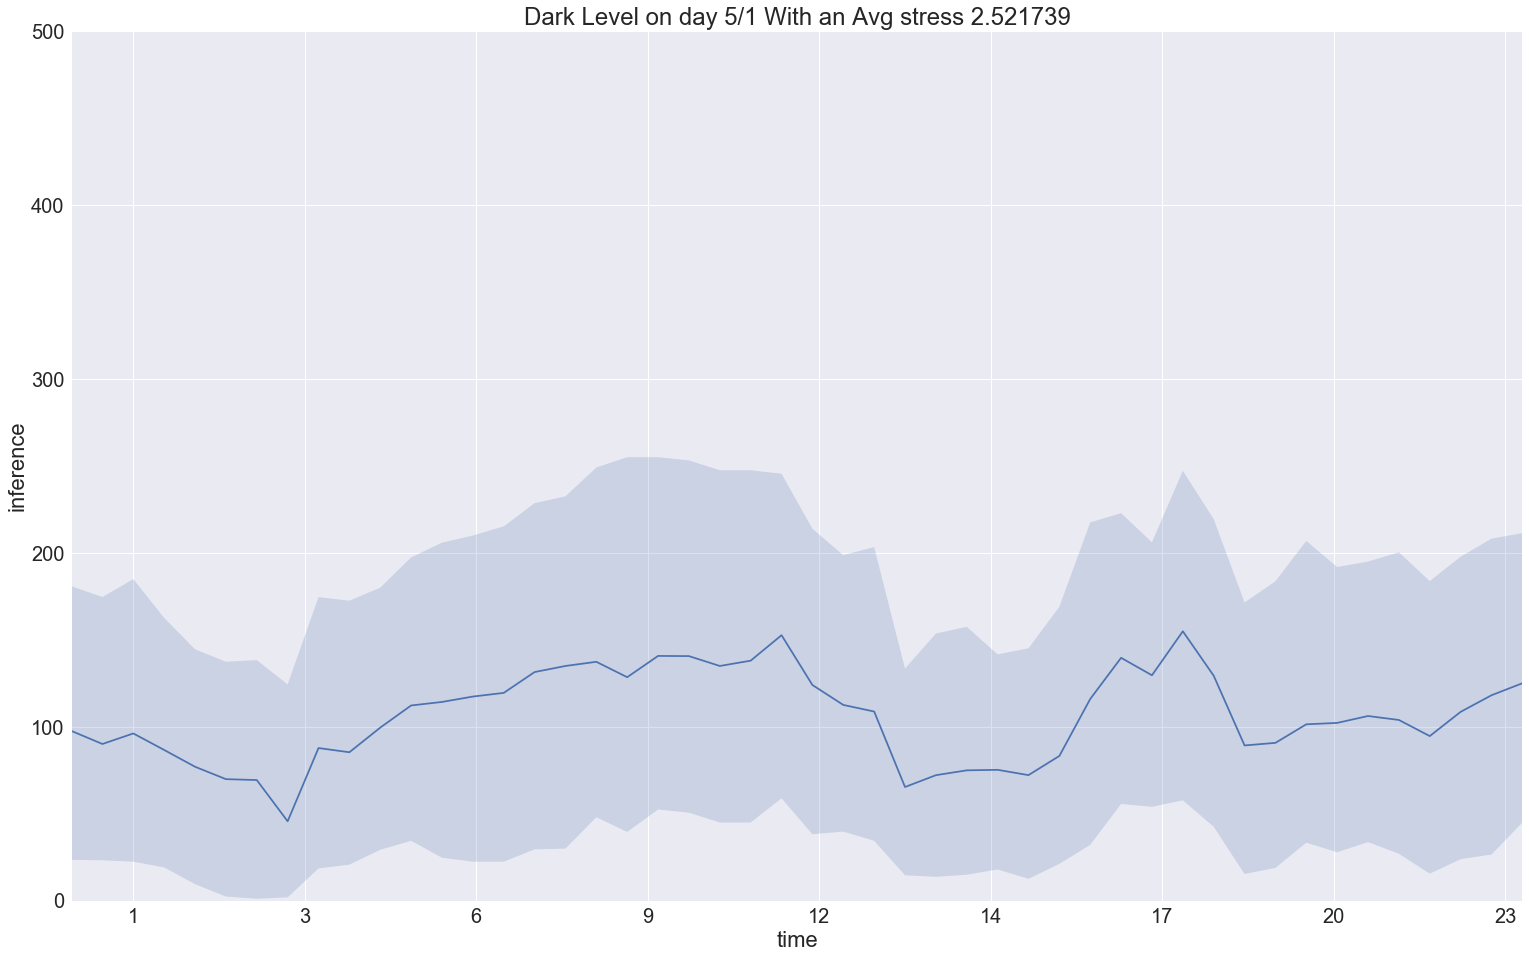

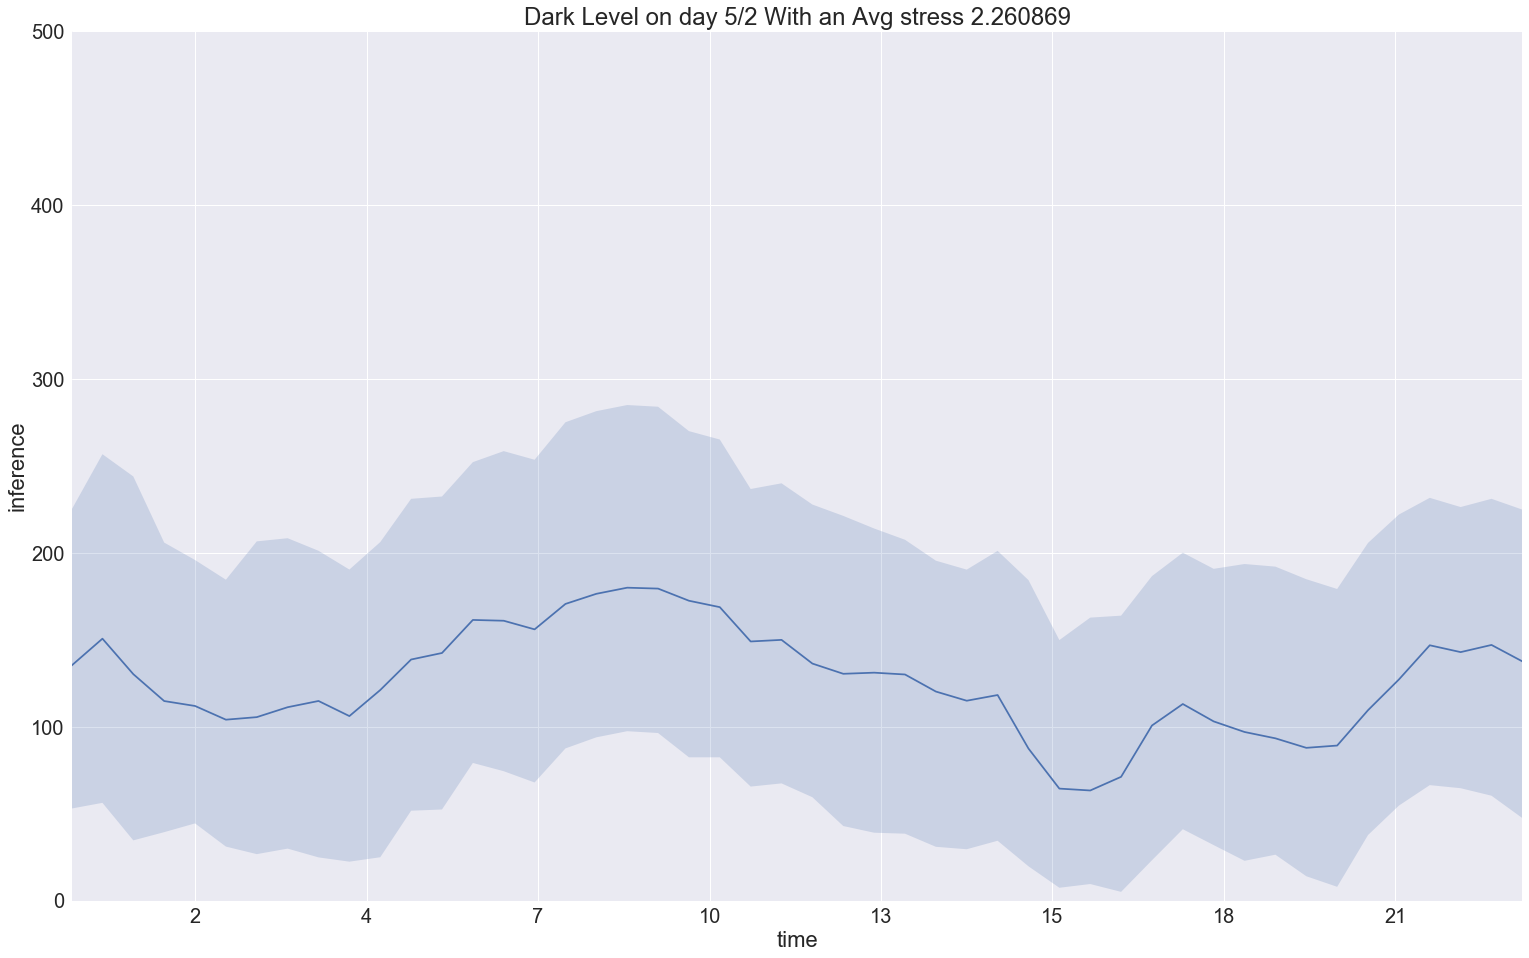

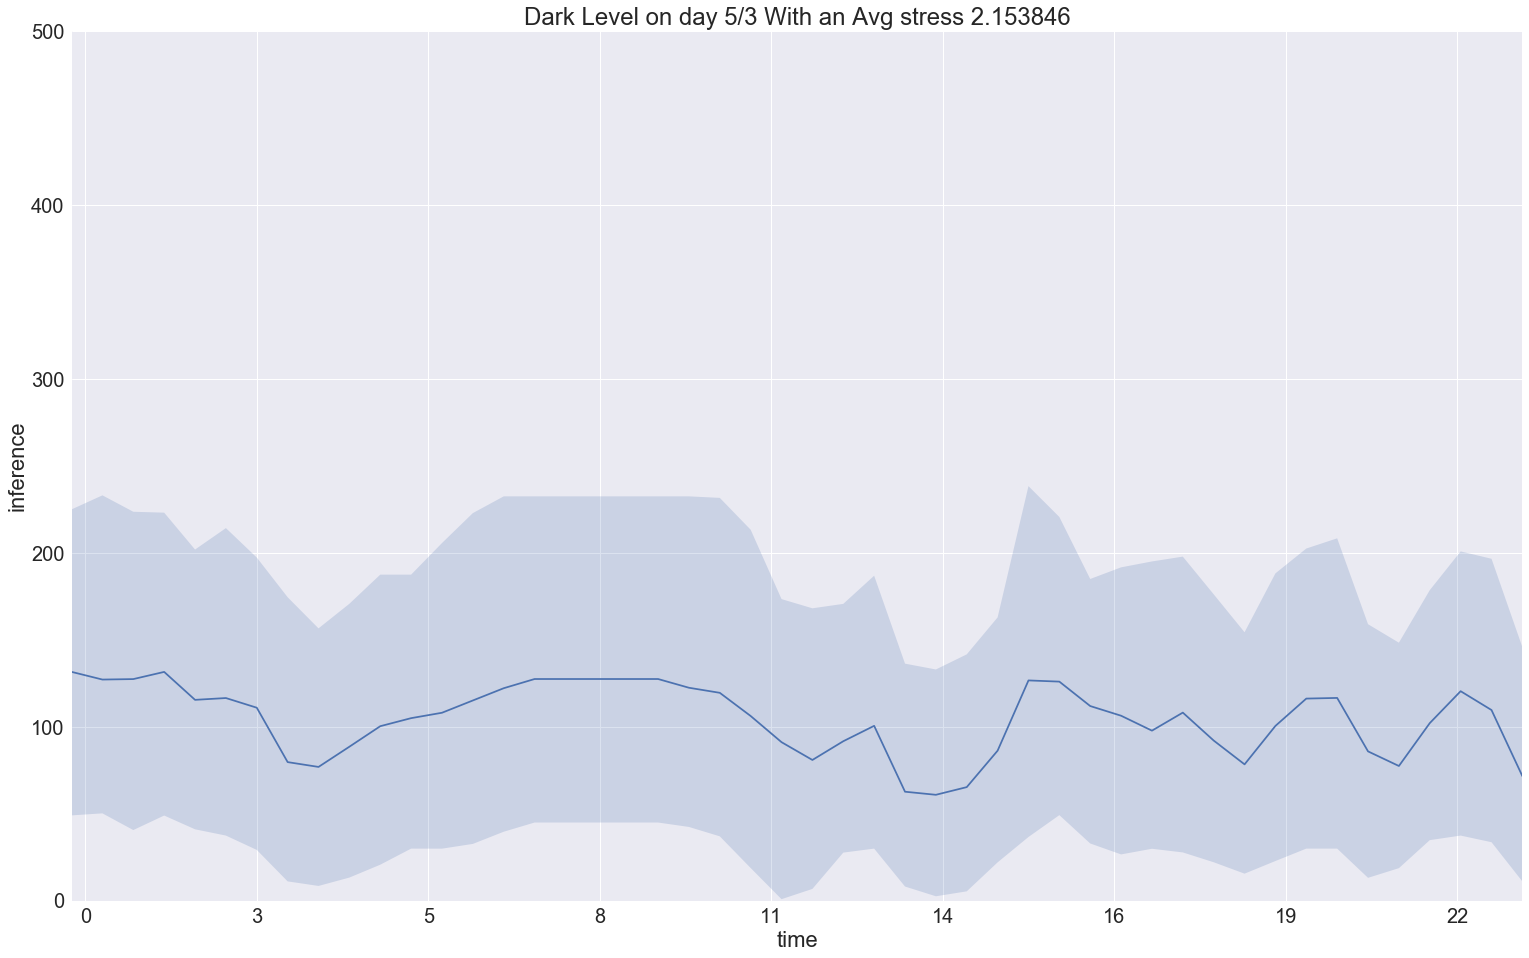

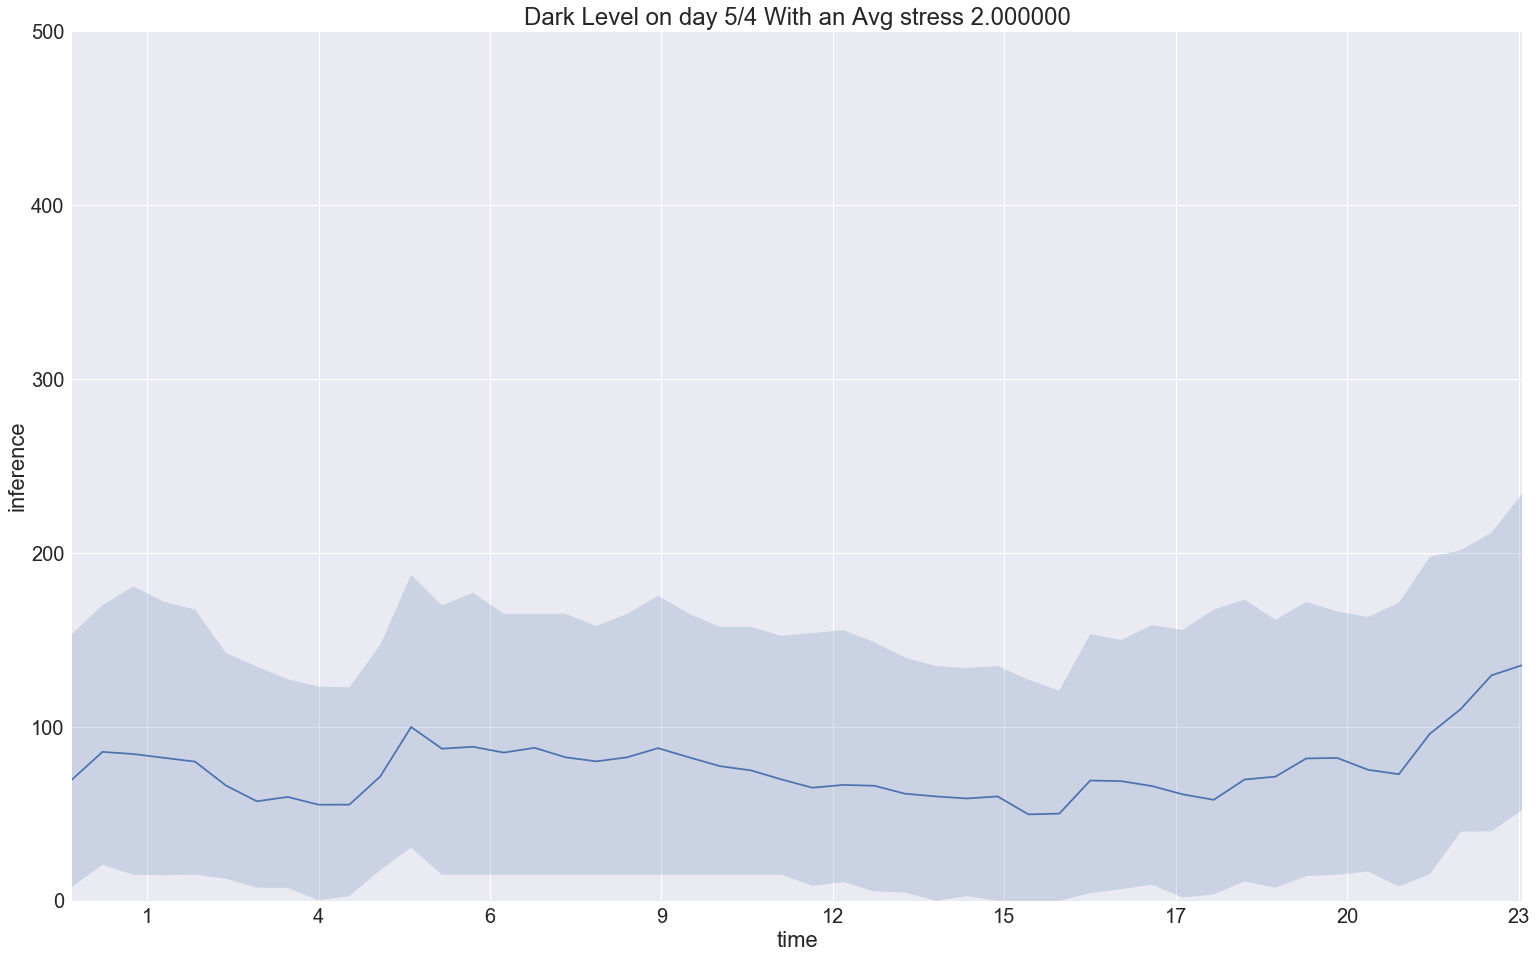

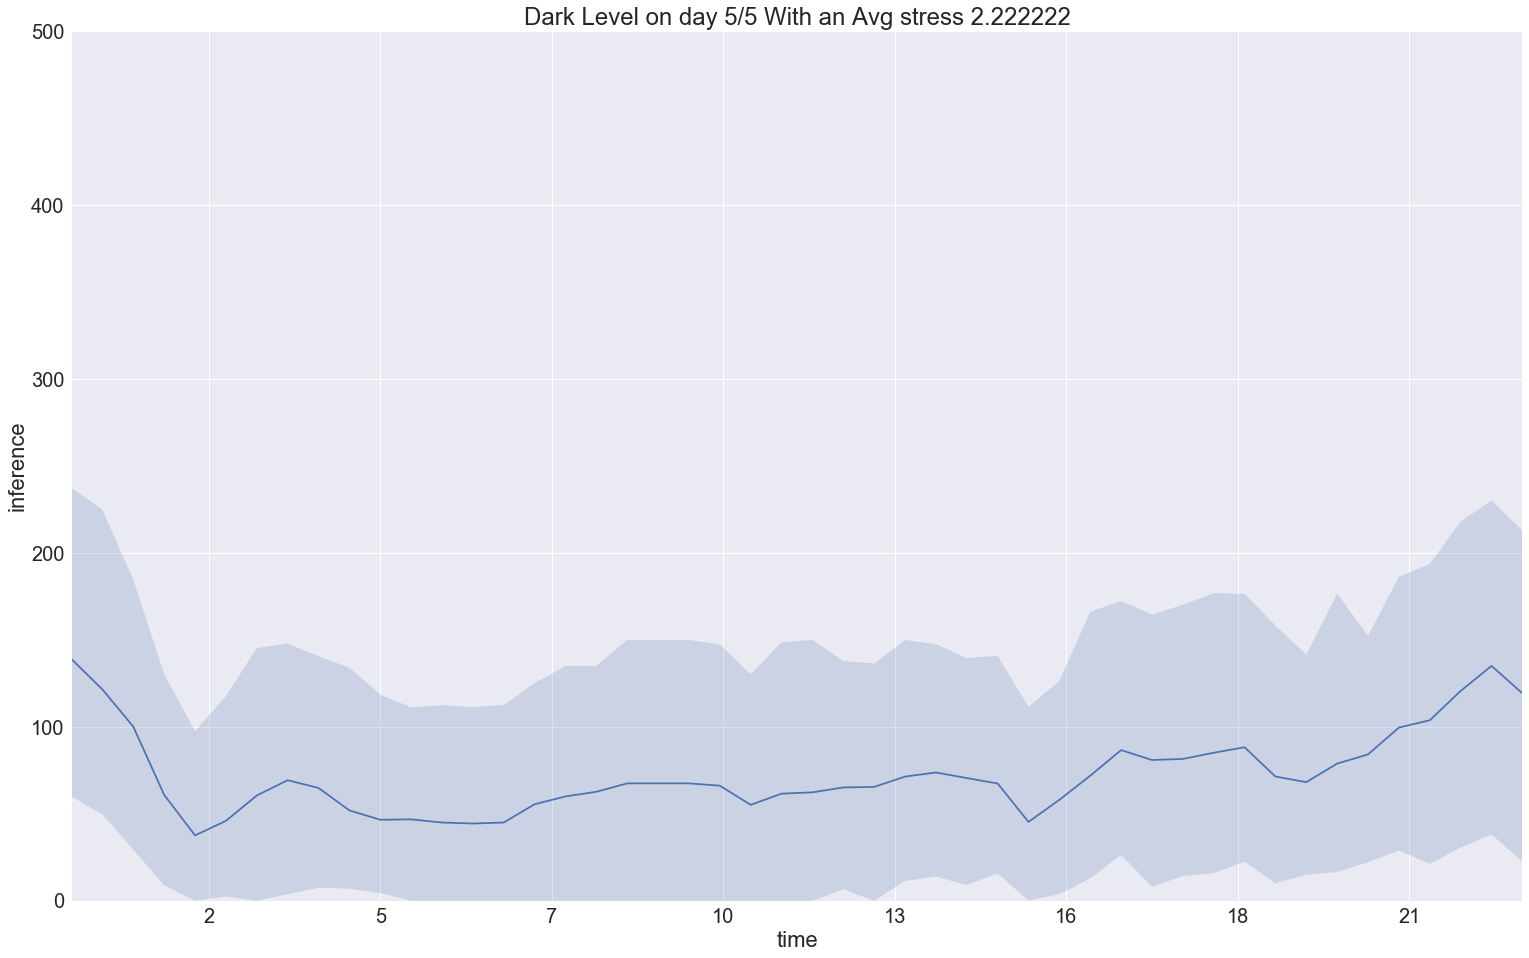

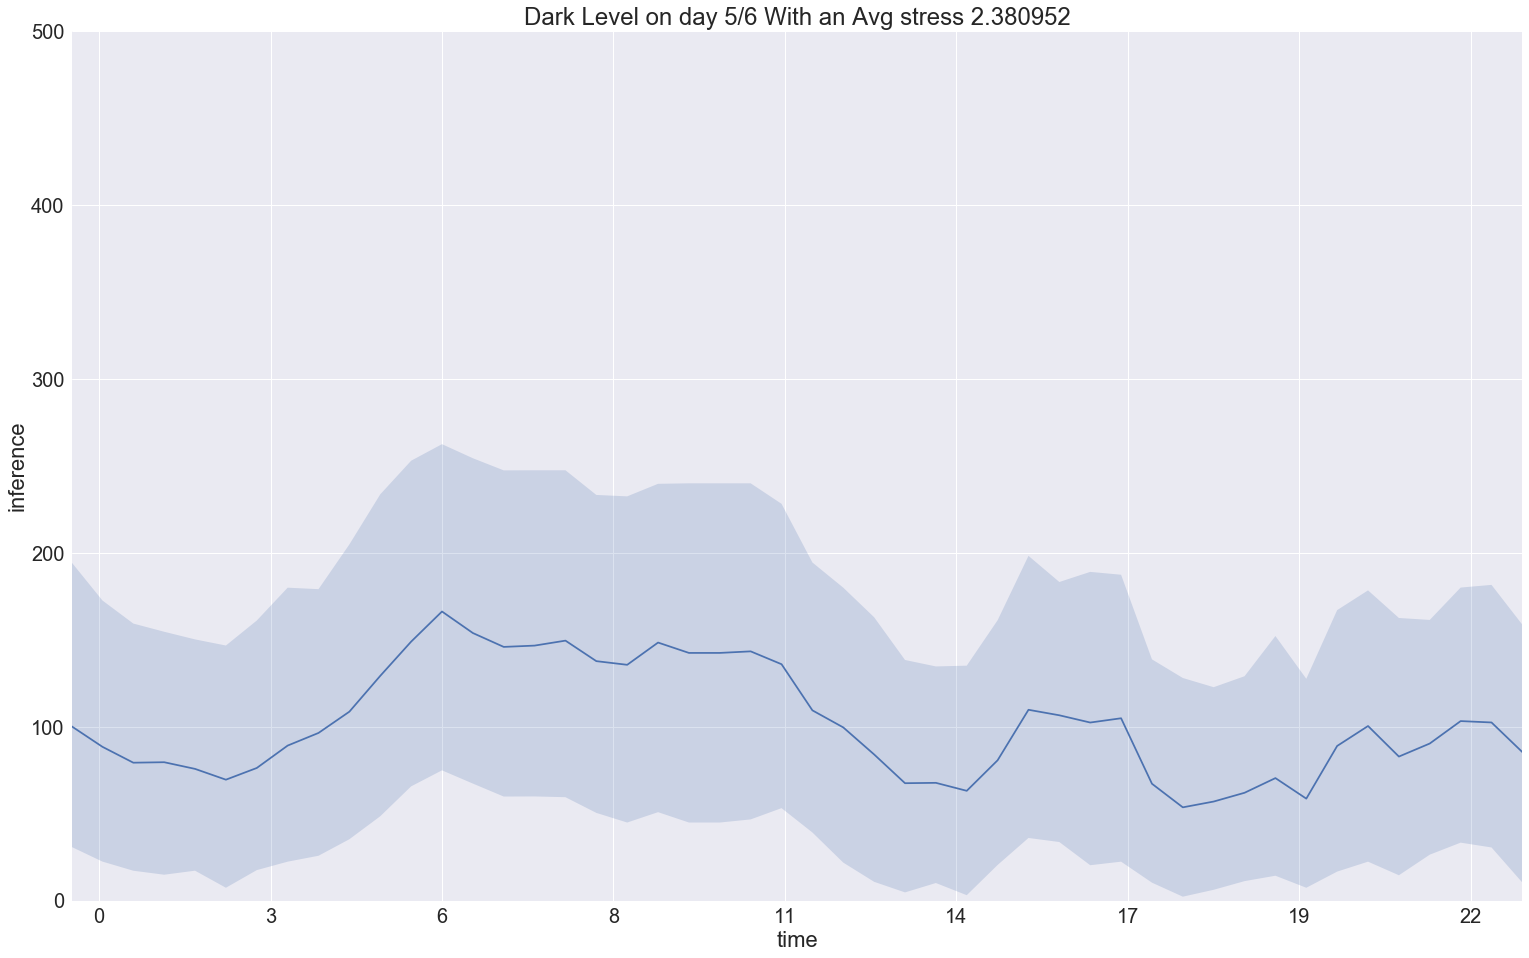

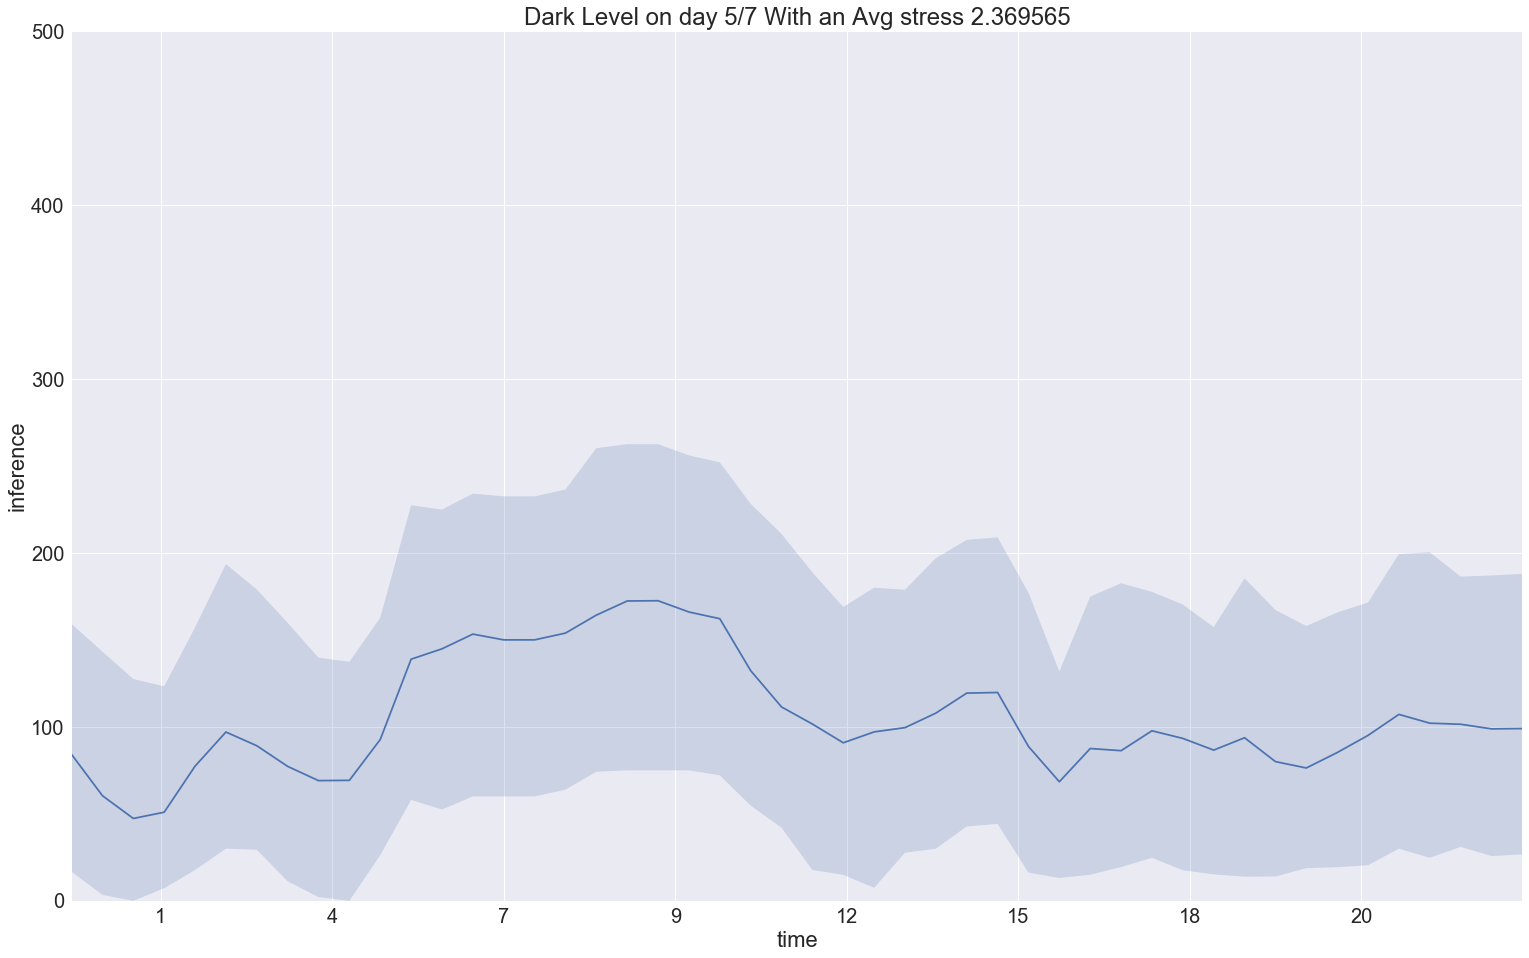

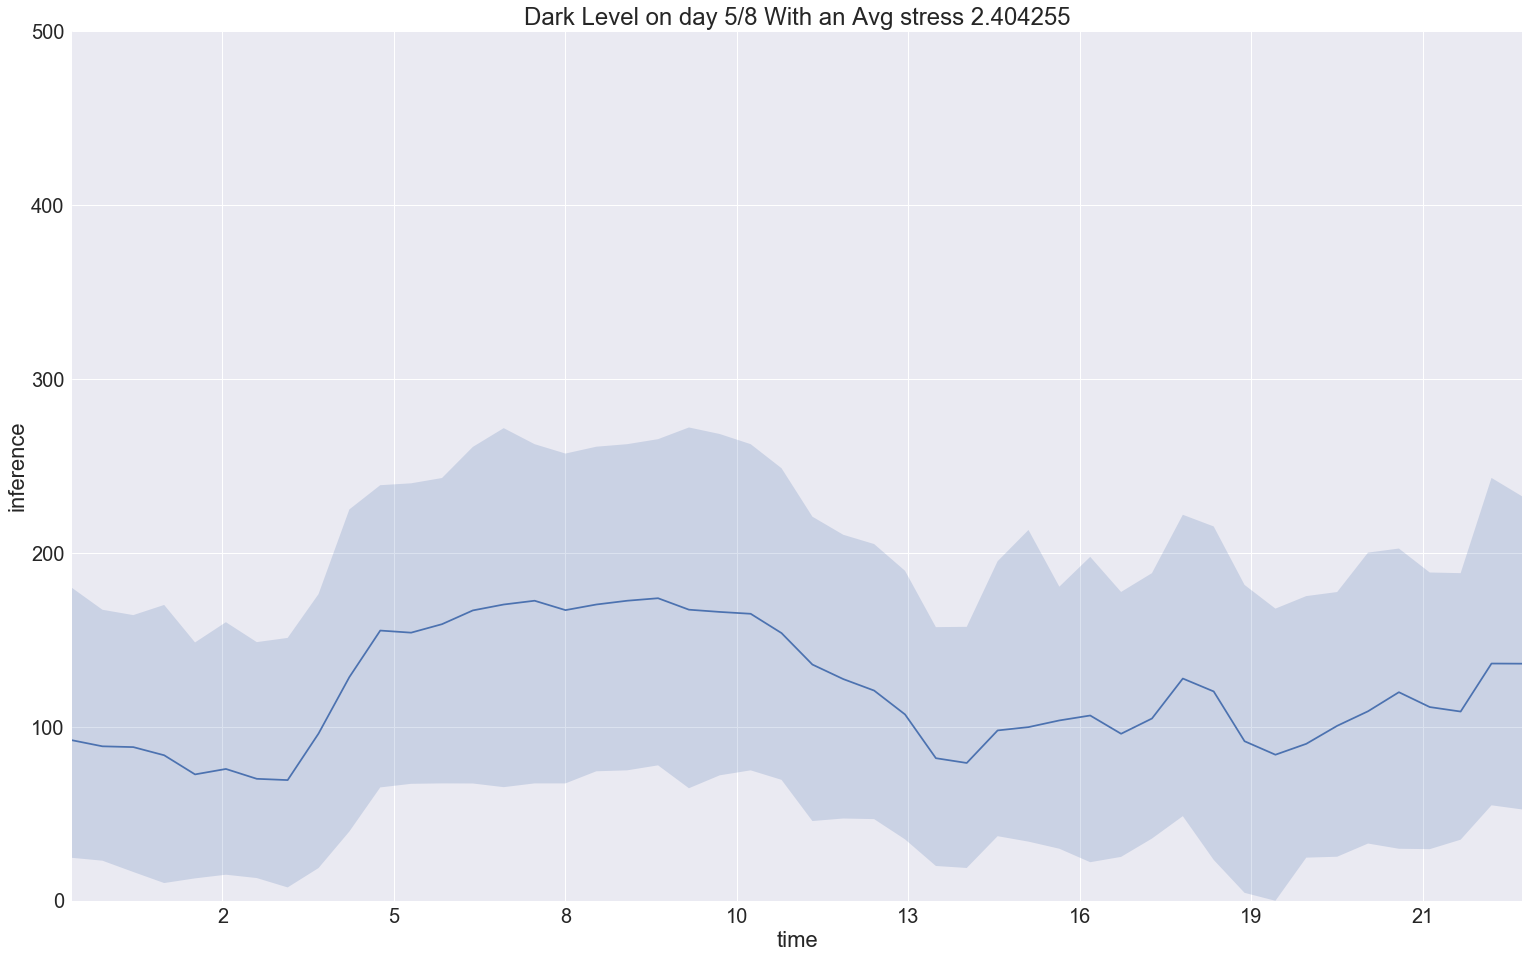

In [29]:
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
# Plotting the values.

def myFormatter(x, pos):
    date_f = pd.to_datetime(x, infer_datetime_format=True)
    return  str(date_f.hour) 

start_date = datetime.datetime.strptime('24-03-13', '%d-%m-%y')
end_date = datetime.datetime.strptime('08-05-13', '%d-%m-%y')
distinct_students = dark_details.student_id.unique()

for day_offset in range(4,46):
    
    # Least stressed day
    stress_day =  start_date + datetime.timedelta(days=day_offset)
    bool_1 =  dark_details['time']  < stress_day + datetime.timedelta(days=1)
    bool_2 =  dark_details['time']  >= stress_day 
    dark_details_day = dark_details[np.logical_and(bool_1, bool_2)]
    dark_details_gen = pd.DataFrame()
    
    for student in distinct_students:
        dark_details_filtered = dark_details_day[dark_details_day['student_id'] == student]
        temp = dark_details_filtered.groupby(pd.Grouper(key='time', freq='30T')).sum()
        temp['student_id'] = student
        dark_details_gen = dark_details_gen.append(temp)
        
    dark_details_gen['unit'] = dark_details_gen.groupby('time').cumcount()+1
    dark_details_gen.reset_index(inplace=True)
    dark_details_gen.reset_index(inplace=True)    
    
    #Extracting avg stress on all student that day.
    avg_stress = stress_level[stress_level["date"] == stress_day]['avg_stress_level']
    avg_stress = avg_stress.values[0]
    
    sns.set(font_scale = 2)
    sns.set_style("darkgrid")
    
    fig, ax = plt.subplots(figsize=(26,16))
    ax.set_ylim((0,500))
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(myFormatter))
    ax.set_title("Dark Level on day " + str(stress_day.month) +"/"+str(stress_day.day)+" With an Avg stress "+str(avg_stress))
    ax.set_xlabel('Hour')
    ax.set_ylabel("Dark Levels")
    sns.tsplot(data=dark_details_gen, time='time', value='inference', unit='unit',  ci=[100], ax=ax)
    fig.show()
    fig.savefig("F:\\Projects\\StudentLife-ML-Analysis\\Vizualization\\Plots\\LightLevelsViz\\Light_level_viz_all_studs_day_"+str(day_offset)+".jpg")


